<a href="https://colab.research.google.com/github/MAI3003-Data-Witches/Data-Witches_Project1/blob/main/MAI3003_Data_Witches_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAI3003 - Data Witches**

| **Name**         | **Student ID** |
|------------------|----------------|
| Claessen, VVHJAE | i6339543       |
| Ovsiannikova, AM | i6365923       |
| Pubben, J        | i6276134       |
| Roca Cugat, M    | i6351071       |
| Záboj, J         | i6337952       |

# Logbook

▶▶**Please make a copy of the notebook to work in. Let's keep this one as our final notebook (and updated with code ofc).**◀◀

**Changes**
Also see Git Commit History.

| **Version** | **Changes**      | **Date** |
|-------------|------------------|----------|
| v0.0        | Dataset loaded   | 02-11-25 |
| v0.1        | Data exploration | 05-11-25 |
| v0.2        | Data cleaning    | 05-11-25 |


## Methods

Let's ensure we all use the same names for all components.  

| **Variable**         | **Name**       |
|----------------------|----------------|
| Dataframe (raw)      | hcv            |
| Encoded dataframe    | hcv_encoded    |
| Imputed dataframe    | hcv_imputed    |
| Dataframe unskewed   | hcv_unskewed   |
| Dataframe normalized | hcv_normalized |

| **Function**              | **Description**                        | **Arguments**                                    |
|---------------------------|----------------------------------------|--------------------------------------------------|
| corr_plot()               | Correlation plot                       | df                                               |
| distplots()               | Distribution plots                     | df                                               |
| drop_high_missing_cols()  | Drop columns with missings             | df, threshold                                    |
| _reconstruct_dataframe()  | Reconstruction function for imputation | encoded_df, original_df, num_cols, cat_cols, enc |
| knn_impute()              | Distribution plots                     | df, min_thresh, max_thresh, n_neighbors          |
| impute_simple_central()   | Distribution plots                     | df, max_thresh                                   |
| normality_check_and_fix() | Distribution plots                     | df                                               |
| skewness_check()          | Distribution plots                     | df                                               |
| model_evaluation()        | Model evaluation                       | model                                            |
| model_desc()              | Model statistics                       | model                                            |


# Preamble

## Libraries and other imports

In [124]:
import sys
if 'google.colab' in sys.modules:
    !pip install -r requirements.txt

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style

from scipy import stats
from scipy.stats import levene

import statsmodels.api as sm

import numpy as np
from numpy.ma.core import indices

import sklearn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay, precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap

import warnings

In [126]:
missing  = 0
misVariables = []
sklearn.set_config(transform_output="pandas")
print(Style.RESET_ALL)

# Change False to True during development, they are used to ignore warnings when in "prod".
if True: warnings.filterwarnings('ignore')


### Load dataset

In [127]:
hcv = pd.read_csv('https://archive.ics.uci.edu/static/public/571/data.csv')

hcv

ID  Age Sex   ALB    ALP    ALT    AST   BIL    CHE  CHOL   CREA    CGT  \
0      1   32   m  38.5   52.5    7.7   22.1   7.5   6.93  3.23  106.0   12.1   
1      2   32   m  38.5   70.3   18.0   24.7   3.9  11.17  4.80   74.0   15.6   
2      3   32   m  46.9   74.7   36.2   52.6   6.1   8.84  5.20   86.0   33.2   
3      4   32   m  43.2   52.0   30.6   22.6  18.9   7.33  4.74   80.0   33.8   
4      5   32   m  39.2   74.1   32.6   24.8   9.6   9.15  4.32   76.0   29.9   
..   ...  ...  ..   ...    ...    ...    ...   ...    ...   ...    ...    ...   
610  611   62   f  32.0  416.6    5.9  110.3  50.0   5.57  6.30   55.7  650.9   
611  612   64   f  24.0  102.8    2.9   44.4  20.0   1.54  3.02   63.0   35.9   
612  613   64   f  29.0   87.3    3.5   99.0  48.0   1.66  3.63   66.7   64.2   
613  614   46   f  33.0    NaN   39.0   62.0  20.0   3.56  4.20   52.0   50.0   
614  615   59   f  36.0    NaN  100.0   80.0  12.0   9.07  5.30   67.0   34.0   

     PROT       Category  
0    69.0  0=Blood Donor  
1    76.5  0=Blood Donor  
2    79.3  0=Blood Donor  
3    75.7  0=Blood Donor  
4    68.7  0=Blood Donor  
..    ...            ...  
610  68.5    3=Cirrhosis  
611  71.3    3=Cirrhosis  
612  82.0    3=Cirrhosis  
613  71.0    3=Cirrhosis  
614  68.0    3=Cirrhosis  

[615 rows x 14 columns]

## Function declarations

### Graphs

#### Correlation plot

In [128]:
def corr_plot(input_df):
    sns.set_theme(style="white")
    corr = input_df.select_dtypes('number').corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(20, 5))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,annot = False,
                 linewidths=.5, cbar_kws={"shrink": .8})

#### Distribution plots

In [129]:
def distplots(df):
    numeric_df = df.select_dtypes(include=['number'])
    num_features = len(numeric_df.columns)
    cols = int(np.ceil(np.sqrt(num_features)))
    rows = int(np.ceil(num_features / cols))

    # A figure with subplots looks much nicer
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, column in enumerate(numeric_df.columns):
        # Technically not needed but might as well
        numeric_df_nona = numeric_df[column].dropna()

        axes[i].hist(numeric_df_nona, bins=30, alpha=0.7, edgecolor='black')

        if len(numeric_df_nona) > 1:
            density = stats.gaussian_kde(numeric_df_nona)
            xs = np.linspace(numeric_df_nona.min(), numeric_df_nona.max(), 200)
            axes[i].plot(xs, density(xs) * len(numeric_df_nona) * (numeric_df_nona.max() - numeric_df_nona.min()) / 30,
                         'r-', linewidth=2)

        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Number of Patients')
        axes[i].set_title(f'Distribution of {column}')
        axes[i].grid(axis='y', alpha=0.3)

    # Remove any empty subplots if they exist
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Imputation

#### Drop high missing columns

In [130]:
def drop_high_missing_cols(df, threshold):
    """
    1. Drops columns with a high percentage of missing values.
    """
    print(f"--- Running Step 1: Dropping columns > {threshold:.0%} missing ---")
    # Calculate missing percentage on the dataframe
    missing_pct = df.isnull().sum() / len(df)

    # Identify columns to drop based on the threshold
    cols_to_drop = missing_pct[missing_pct >= threshold].index.tolist()

    if cols_to_drop:
        print(f"   -> Dropping columns: {', '.join(cols_to_drop)}")
        # Drop columns from the dataframe
        df_dropped = df.drop(columns=cols_to_drop)
    else:
        print("   -> No columns exceeded the missing value threshold.")
        df_dropped = df.copy()

    return df_dropped

#### Dataframe reconstruction


In [131]:
def _reconstruct_dataframe(encoded_df, original_df, num_cols, cat_cols, enc):
    """
    Internal helper function to revert a one-hot encoded DataFrame
    back to its original shape.
    """
    # Isolate the imputed numerical data
    # Ensure we only select num_cols that are still in the encoded_df
    present_num_cols = [col for col in num_cols if col in encoded_df.columns]
    imputed_numerical = encoded_df[present_num_cols]

    # Isolate the encoded columns to be inverse-transformed
    encoded_cols_names = enc.get_feature_names_out(cat_cols)

    # Ensure all expected encoded columns are present, fill with 0 if not
    for col in encoded_cols_names:
        if col not in encoded_df.columns:
            encoded_df[col] = 0

    imputed_encoded = encoded_df[encoded_cols_names]

    # Perform the inverse transform
    imputed_categorical_array = enc.inverse_transform(imputed_encoded)

    # Convert the result back to a DataFrame
    imputed_categorical = pd.DataFrame(imputed_categorical_array,
                                       columns=cat_cols,
                                       index=encoded_df.index)

    # Combine numerical and reverted categorical data
    reconstructed_df = pd.concat([imputed_numerical, imputed_categorical], axis=1)

    # Enforce the original column order
    # Use .columns.intersection() to avoid errors if columns were dropped
    original_cols_present = original_df.columns.intersection(reconstructed_df.columns)
    final_df = reconstructed_df.reindex(columns=original_cols_present)

    return final_df

#### KNN imputation

In [132]:
def knn_impute(df, min_thresh, max_thresh, n_neighbors):
    """
    2. Uses KNN Imputation for columns with moderate missing values (5%-50%).

    What the function does:
    - One-hot encodes categorical data.
    - Trains KNN models (Regressor or Classifier) on the data
      to predict its own missing values.
    - Reconstructs the dataframe back to its original format.
    """
    print(f"\n--- Running Step 2: KNN Imputation ({min_thresh:.0%} - {max_thresh:.0%} missing) ---")
    # Create a copy to avoid modifying the original dataframe
    df_imputed = df.copy()

    # --- 1. One-Hot Encoding ---

    # Identify categorical/numerical columns
    categorical_cols = [col for col in df_imputed.columns
                        if df_imputed[col].dtype == 'object']
    numerical_cols = [col for col in df_imputed.columns
                      if df_imputed[col].dtype != 'object']

    # Initialize encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Handle case with no categorical columns
    if not categorical_cols:
        print("   -> No categorical columns found. Skipping encoding.")
        df_encoded = df_imputed.copy()
        encoder = None  # Flag that no encoder was used
    else:
        print(f"   -> Fitting OneHotEncoder on {len(categorical_cols)} columns...")
        # Fit and transform the data
        encoded_cols_df = pd.DataFrame(encoder.fit_transform(df_imputed[categorical_cols]),
                                       columns=encoder.get_feature_names_out(categorical_cols),
                                       index=df_imputed.index)

        # Create the new, fully encoded dataframe
        df_encoded = df_imputed.drop(columns=categorical_cols).join(encoded_cols_df)
        print(f"   -> Data encoded. New shape: {df_encoded.shape}")

    # --- 2. KNN Imputation on Data ---

    # Calculate means *once* to be used for filling features (not targets)
    feature_fill_values = df_encoded.mean()

    for col in df_encoded.columns:
        missing_pct = df_encoded[col].isnull().mean()

        # Apply KNN to columns with moderate missingness
        if min_thresh <= missing_pct <= max_thresh:
            print(f"   -> KNN Imputing '{col}' (Missing: {missing_pct:.2%})")

            other_cols = [c for c in df_encoded.columns if c != col]

            # Split data for the imputer model
            train_rows = df_encoded[col].notnull()
            predict_rows = df_encoded[col].isnull()

            # If no rows to predict, skip
            if not predict_rows.any():
                print(f"      -> Skipping '{col}', no rows to predict.")
                continue

            # Fill NaNs in *features* with the mean for model stability
            X_train = df_encoded.loc[train_rows, other_cols].fillna(feature_fill_values)
            y_train = df_encoded.loc[train_rows, col]
            X_predict = df_encoded.loc[predict_rows, other_cols].fillna(feature_fill_values)

            # Select and train the appropriate KNN model
            is_binary = y_train.nunique() <= 2
            model = KNeighborsClassifier(n_neighbors=n_neighbors) if is_binary else KNeighborsRegressor(
                n_neighbors=n_neighbors)

            model.fit(X_train, y_train)
            predicted_values = model.predict(X_predict)

            # Assign the predicted values back to the encoded dataframe
            df_encoded.loc[predict_rows, col] = predicted_values
            print(f"      -> Successfully imputed {len(predicted_values)} values.")

    # --- 3. Reconstruct DataFrame ---

    # If no encoding was done, just return the dataframe
    if encoder is None:
        print("   -> Skipping reconstruction (no categorical columns).")
        return df_encoded

    print("   -> Reconstructing dataframe...")
    # Reconstruct the dataframe
    df_reconstructed = _reconstruct_dataframe(
        df_encoded,
        df_imputed,  # Pass the original copy for column order
        numerical_cols,
        categorical_cols,
        encoder
    )
    df_reconstructed.sort_index(inplace=True)

    return df_reconstructed

#### Normal imputation

In [133]:
def impute_simple_central(df, max_thresh):
    """
    3. Uses simple imputation (median/mode) for columns with < 5% missing values.

    This function learns the imputation value (median for numeric, mode for
    categorical) from the dataframe and applies it to fill its own NaNs.
    """
    print(f"\n--- Running Step 3: Simple Imputation (< {max_thresh:.0%} missing) ---")
    df_imputed = df.copy()

    for col in df_imputed.columns:
        # Calculate the percentage of missing values
        missing_pct = df_imputed[col].isnull().mean()

        # Check if the column fits the < 5% criteria
        if 0 < missing_pct < max_thresh:
            print(f"   -> Found '{col}' with {missing_pct:.2%} missing values. Imputing...")

            # Distinguish between numerical and categorical data
            if pd.api.types.is_numeric_dtype(df_imputed[col]):
                # For numerical columns, use the median
                fill_value = df_imputed[col].median()
                df_imputed[col].fillna(fill_value, inplace=True)
                print(f"      -> Filled with median: {fill_value}")
            else:
                # For categorical columns, use the mode
                fill_value = df_imputed[col].mode()[0]
                df_imputed[col].fillna(fill_value, inplace=True)
                print(f"      -> Filled with mode: '{fill_value}'")

    print("   -> Simple imputation complete.")
    return df_imputed

### Data cleaning

#### Data encoding

In [134]:
def encode_categorical(df):
    df_encoded = df.copy()

    categorical_cols = hcv.select_dtypes(include=['object']).columns

    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(hcv[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded '{col}': {hcv[col].unique()[:5]} -> {df_encoded[col].unique()[:5]}")

    return df_encoded

#### Normality check and correction

In [135]:
def normality_check_and_fix(df):
    df_normalized = df.copy()
    print("Shapiro-Wilk Normality Test")

    for column in df.columns:
        data_nona = df[column].dropna()
        stat, p_value = stats.shapiro(data_nona)

        if p_value > 0.05:
            print(Fore.GREEN + f"{column}: Normal (p={p_value:.4f})")
        else:
            print(Fore.RED + f"{column}: Not Normal (p={p_value:.4f})")
            df_normalized[column] = normalize(df[column])
    print(Style.RESET_ALL)
    return df_normalized

In [136]:
def normalize(df): # Only to be run on non-normal columns
    data_nona = df.dropna()
    skewness = stats.skew(data_nona)
    df_normalized = df.copy()
    if skewness > 0.5:  # Right-skewed
        # Log transformation (with handling of zero-values)
        if (data_nona > 0).all():
            df_normalized = np.log(df)
            print(f"      -> Applied log transformation")
        else:
            df_normalized = np.log1p(df)
            print(f"      -> Applied log1p transformation")
    else:
        # Box-Cox transformation (requires positive values)
        if (data_nona > 0).all():
            transformed, _ = stats.boxcox(data_nona)
            df_normalized.loc[data_nona.index] = transformed
            print(f"      -> Applied Box-Cox transformation")
        else:
            # Square root transformation for zero-values
            if (data_nona >= 0).all():
                df_normalized = np.sqrt(df)
                print(f"      -> Applied square root transformation")
            else:
                print(f"      -> Skipped (contains negative values)")

    return df_normalized

#### Skewness check

In [137]:
def skewness_check(df):
    for column in df:
        skewness = stats.skew(df[column])
        if skewness > 1:
            print(Fore.RED + f"{column} is strongly right skewed (skew: {skewness:.3f})")
        elif skewness > 0.5:
            print(Fore.RED + f"{column} is moderately right skewed (skew: {skewness:.3f})")
        elif stats.skew(df[column]) < -1:
            print(Fore.MAGENTA + f"{column} is strongly left skewed (skew: {skewness:.3f})")
        elif stats.skew(df[column]) < -0.5:
            print(Fore.MAGENTA + f"{column} is moderately left skewed (skew: {skewness:.3f})")
        else:
            print(Fore.GREEN + f"{column} is symmetric (skew: {skewness:.3f})")
    print(Style.RESET_ALL)

### Models

#### Model

In [138]:
def model_desc(classifier): #You can add more cross-validation stuffs than what is given
                        #Also look up Cross-validation on sktlearn

    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    ##### Cross-validation #####
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Accuracy : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    RocCurveDisplay.from_estimator(classifier, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

#### Model evaluation

In [139]:
def model_evaluation(classifier):

    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,fmt ='')

    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

# Exploratory Data Analysis

In [140]:
hcv

ID  Age Sex   ALB    ALP    ALT    AST   BIL    CHE  CHOL   CREA    CGT  \
0      1   32   m  38.5   52.5    7.7   22.1   7.5   6.93  3.23  106.0   12.1   
1      2   32   m  38.5   70.3   18.0   24.7   3.9  11.17  4.80   74.0   15.6   
2      3   32   m  46.9   74.7   36.2   52.6   6.1   8.84  5.20   86.0   33.2   
3      4   32   m  43.2   52.0   30.6   22.6  18.9   7.33  4.74   80.0   33.8   
4      5   32   m  39.2   74.1   32.6   24.8   9.6   9.15  4.32   76.0   29.9   
..   ...  ...  ..   ...    ...    ...    ...   ...    ...   ...    ...    ...   
610  611   62   f  32.0  416.6    5.9  110.3  50.0   5.57  6.30   55.7  650.9   
611  612   64   f  24.0  102.8    2.9   44.4  20.0   1.54  3.02   63.0   35.9   
612  613   64   f  29.0   87.3    3.5   99.0  48.0   1.66  3.63   66.7   64.2   
613  614   46   f  33.0    NaN   39.0   62.0  20.0   3.56  4.20   52.0   50.0   
614  615   59   f  36.0    NaN  100.0   80.0  12.0   9.07  5.30   67.0   34.0   

     PROT       Category  
0    69.0  0=Blood Donor  
1    76.5  0=Blood Donor  
2    79.3  0=Blood Donor  
3    75.7  0=Blood Donor  
4    68.7  0=Blood Donor  
..    ...            ...  
610  68.5    3=Cirrhosis  
611  71.3    3=Cirrhosis  
612  82.0    3=Cirrhosis  
613  71.0    3=Cirrhosis  
614  68.0    3=Cirrhosis  

[615 rows x 14 columns]

In [141]:
hcv.describe()

ID         Age         ALB         ALP         ALT         AST  \
count  615.000000  615.000000  614.000000  597.000000  614.000000  615.000000   
mean   308.000000   47.408130   41.620195   68.283920   28.450814   34.786341   
std    177.679487   10.055105    5.780629   26.028315   25.469689   33.090690   
min      1.000000   19.000000   14.900000   11.300000    0.900000   10.600000   
25%    154.500000   39.000000   38.800000   52.500000   16.400000   21.600000   
50%    308.000000   47.000000   41.950000   66.200000   23.000000   25.900000   
75%    461.500000   54.000000   45.200000   80.100000   33.075000   32.900000   
max    615.000000   77.000000   82.200000  416.600000  325.300000  324.000000   

              BIL         CHE        CHOL         CREA         CGT        PROT  
count  615.000000  615.000000  605.000000   615.000000  615.000000  614.000000  
mean    11.396748    8.196634    5.368099    81.287805   39.533171   72.044137  
std     19.673150    2.205657    1.132728    49.756166   54.661071    5.402636  
min      0.800000    1.420000    1.430000     8.000000    4.500000   44.800000  
25%      5.300000    6.935000    4.610000    67.000000   15.700000   69.300000  
50%      7.300000    8.260000    5.300000    77.000000   23.300000   72.200000  
75%     11.200000    9.590000    6.060000    88.000000   40.200000   75.400000  
max    254.000000   16.410000    9.670000  1079.100000  650.900000   90.000000

In [142]:
hcv.dtypes

ID            int64
Age           int64
Sex          object
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
CGT         float64
PROT        float64
Category     object
dtype: object

In [143]:
#Removing ID here because it really clutters up all the analysis later
hcv = hcv.drop(labels='ID', axis=1)

In [144]:
hcv

Age Sex   ALB    ALP    ALT    AST   BIL    CHE  CHOL   CREA    CGT  \
0     32   m  38.5   52.5    7.7   22.1   7.5   6.93  3.23  106.0   12.1   
1     32   m  38.5   70.3   18.0   24.7   3.9  11.17  4.80   74.0   15.6   
2     32   m  46.9   74.7   36.2   52.6   6.1   8.84  5.20   86.0   33.2   
3     32   m  43.2   52.0   30.6   22.6  18.9   7.33  4.74   80.0   33.8   
4     32   m  39.2   74.1   32.6   24.8   9.6   9.15  4.32   76.0   29.9   
..   ...  ..   ...    ...    ...    ...   ...    ...   ...    ...    ...   
610   62   f  32.0  416.6    5.9  110.3  50.0   5.57  6.30   55.7  650.9   
611   64   f  24.0  102.8    2.9   44.4  20.0   1.54  3.02   63.0   35.9   
612   64   f  29.0   87.3    3.5   99.0  48.0   1.66  3.63   66.7   64.2   
613   46   f  33.0    NaN   39.0   62.0  20.0   3.56  4.20   52.0   50.0   
614   59   f  36.0    NaN  100.0   80.0  12.0   9.07  5.30   67.0   34.0   

     PROT       Category  
0    69.0  0=Blood Donor  
1    76.5  0=Blood Donor  
2    79.3  0=Blood Donor  
3    75.7  0=Blood Donor  
4    68.7  0=Blood Donor  
..    ...            ...  
610  68.5    3=Cirrhosis  
611  71.3    3=Cirrhosis  
612  82.0    3=Cirrhosis  
613  71.0    3=Cirrhosis  
614  68.0    3=Cirrhosis  

[615 rows x 13 columns]

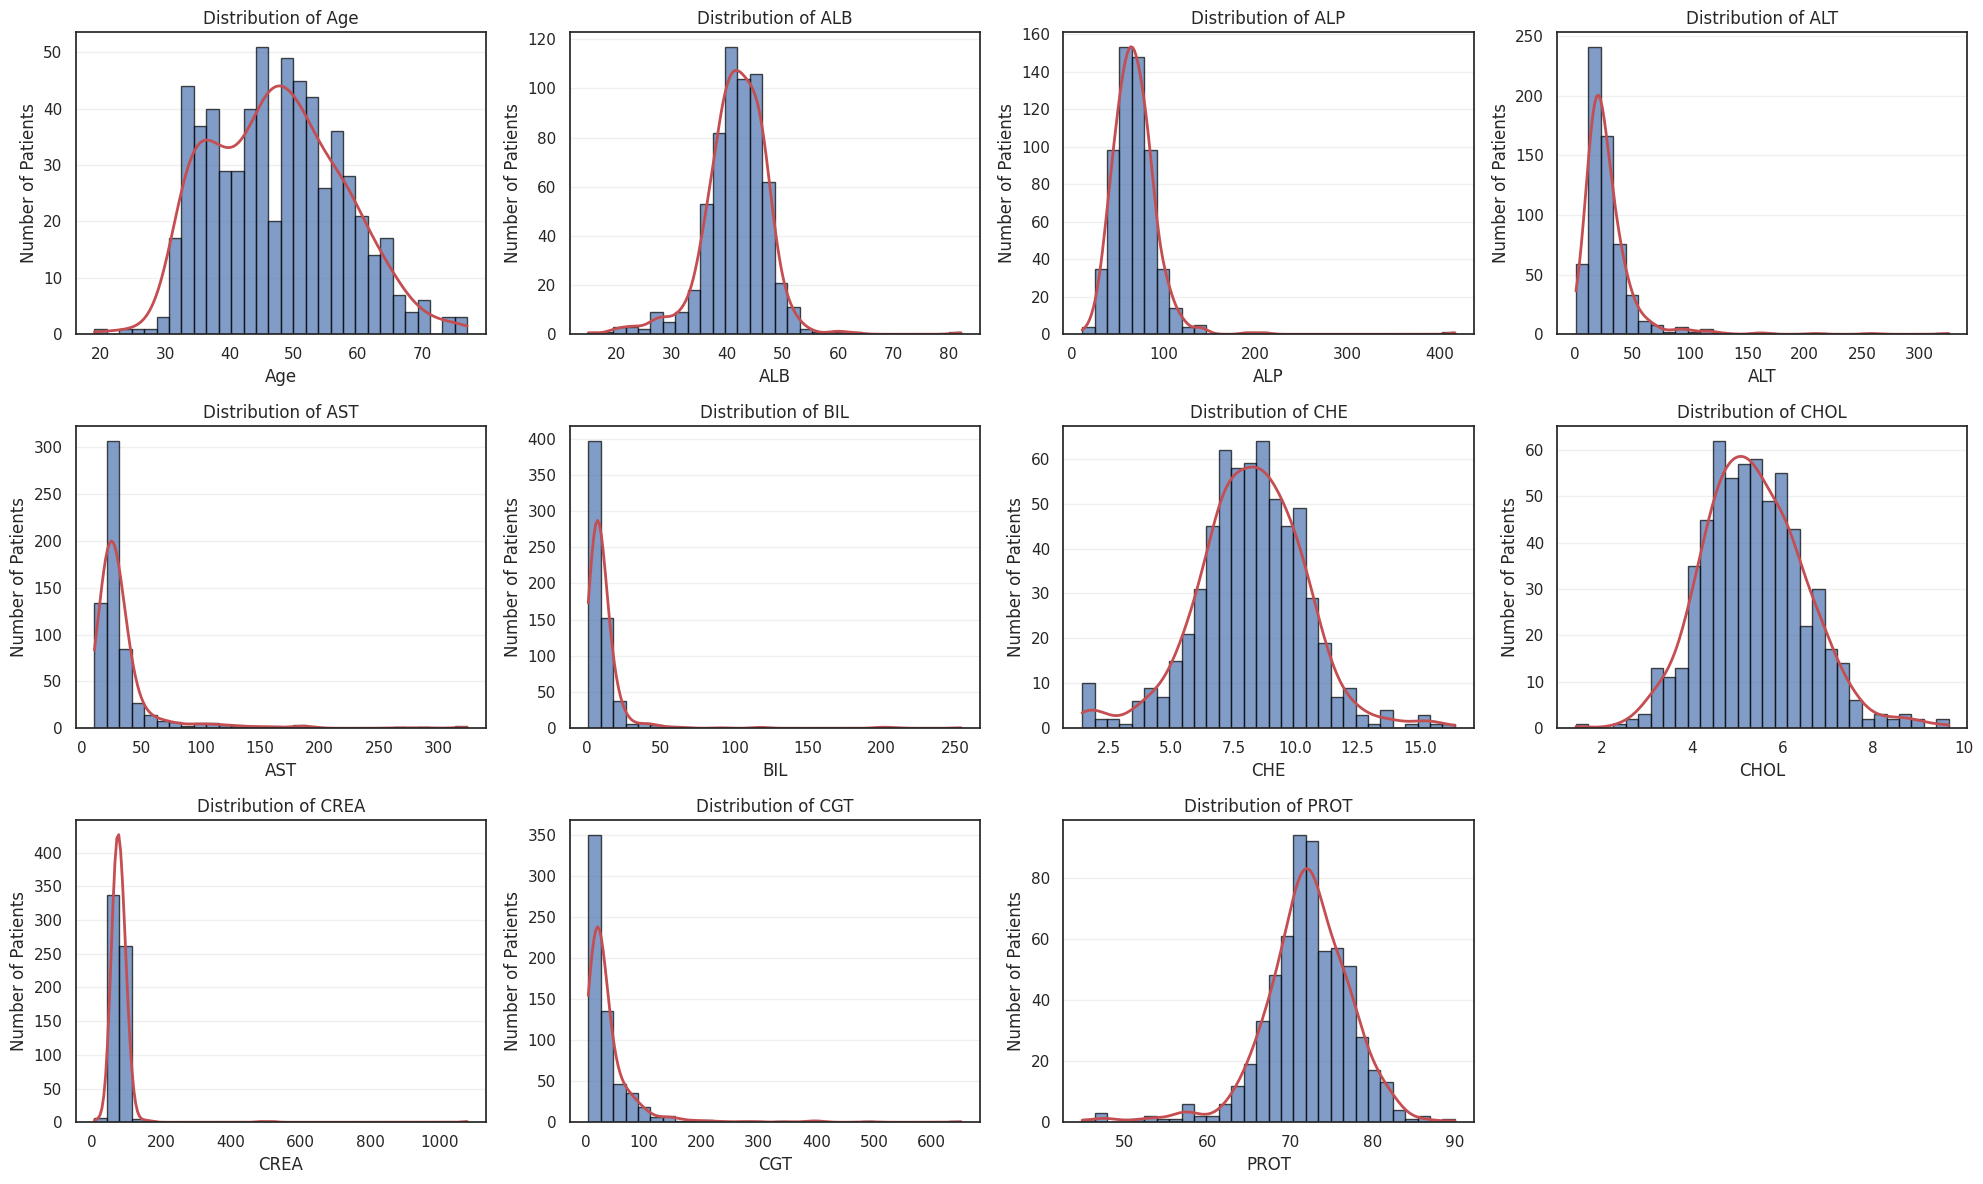

In [145]:
distplots(hcv)

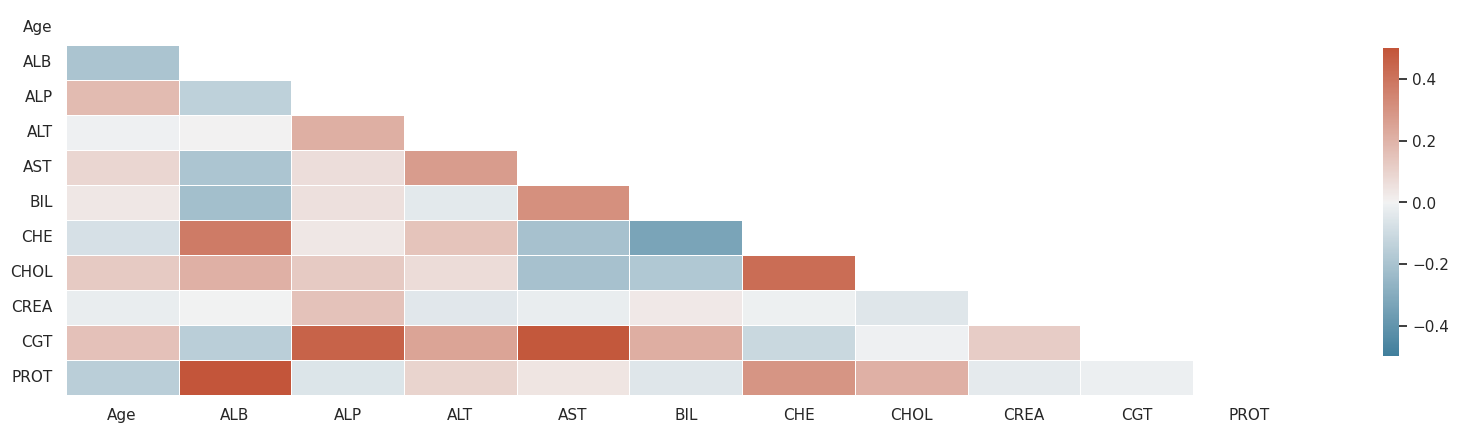

In [146]:
corr_plot(hcv.select_dtypes(include=['number']))

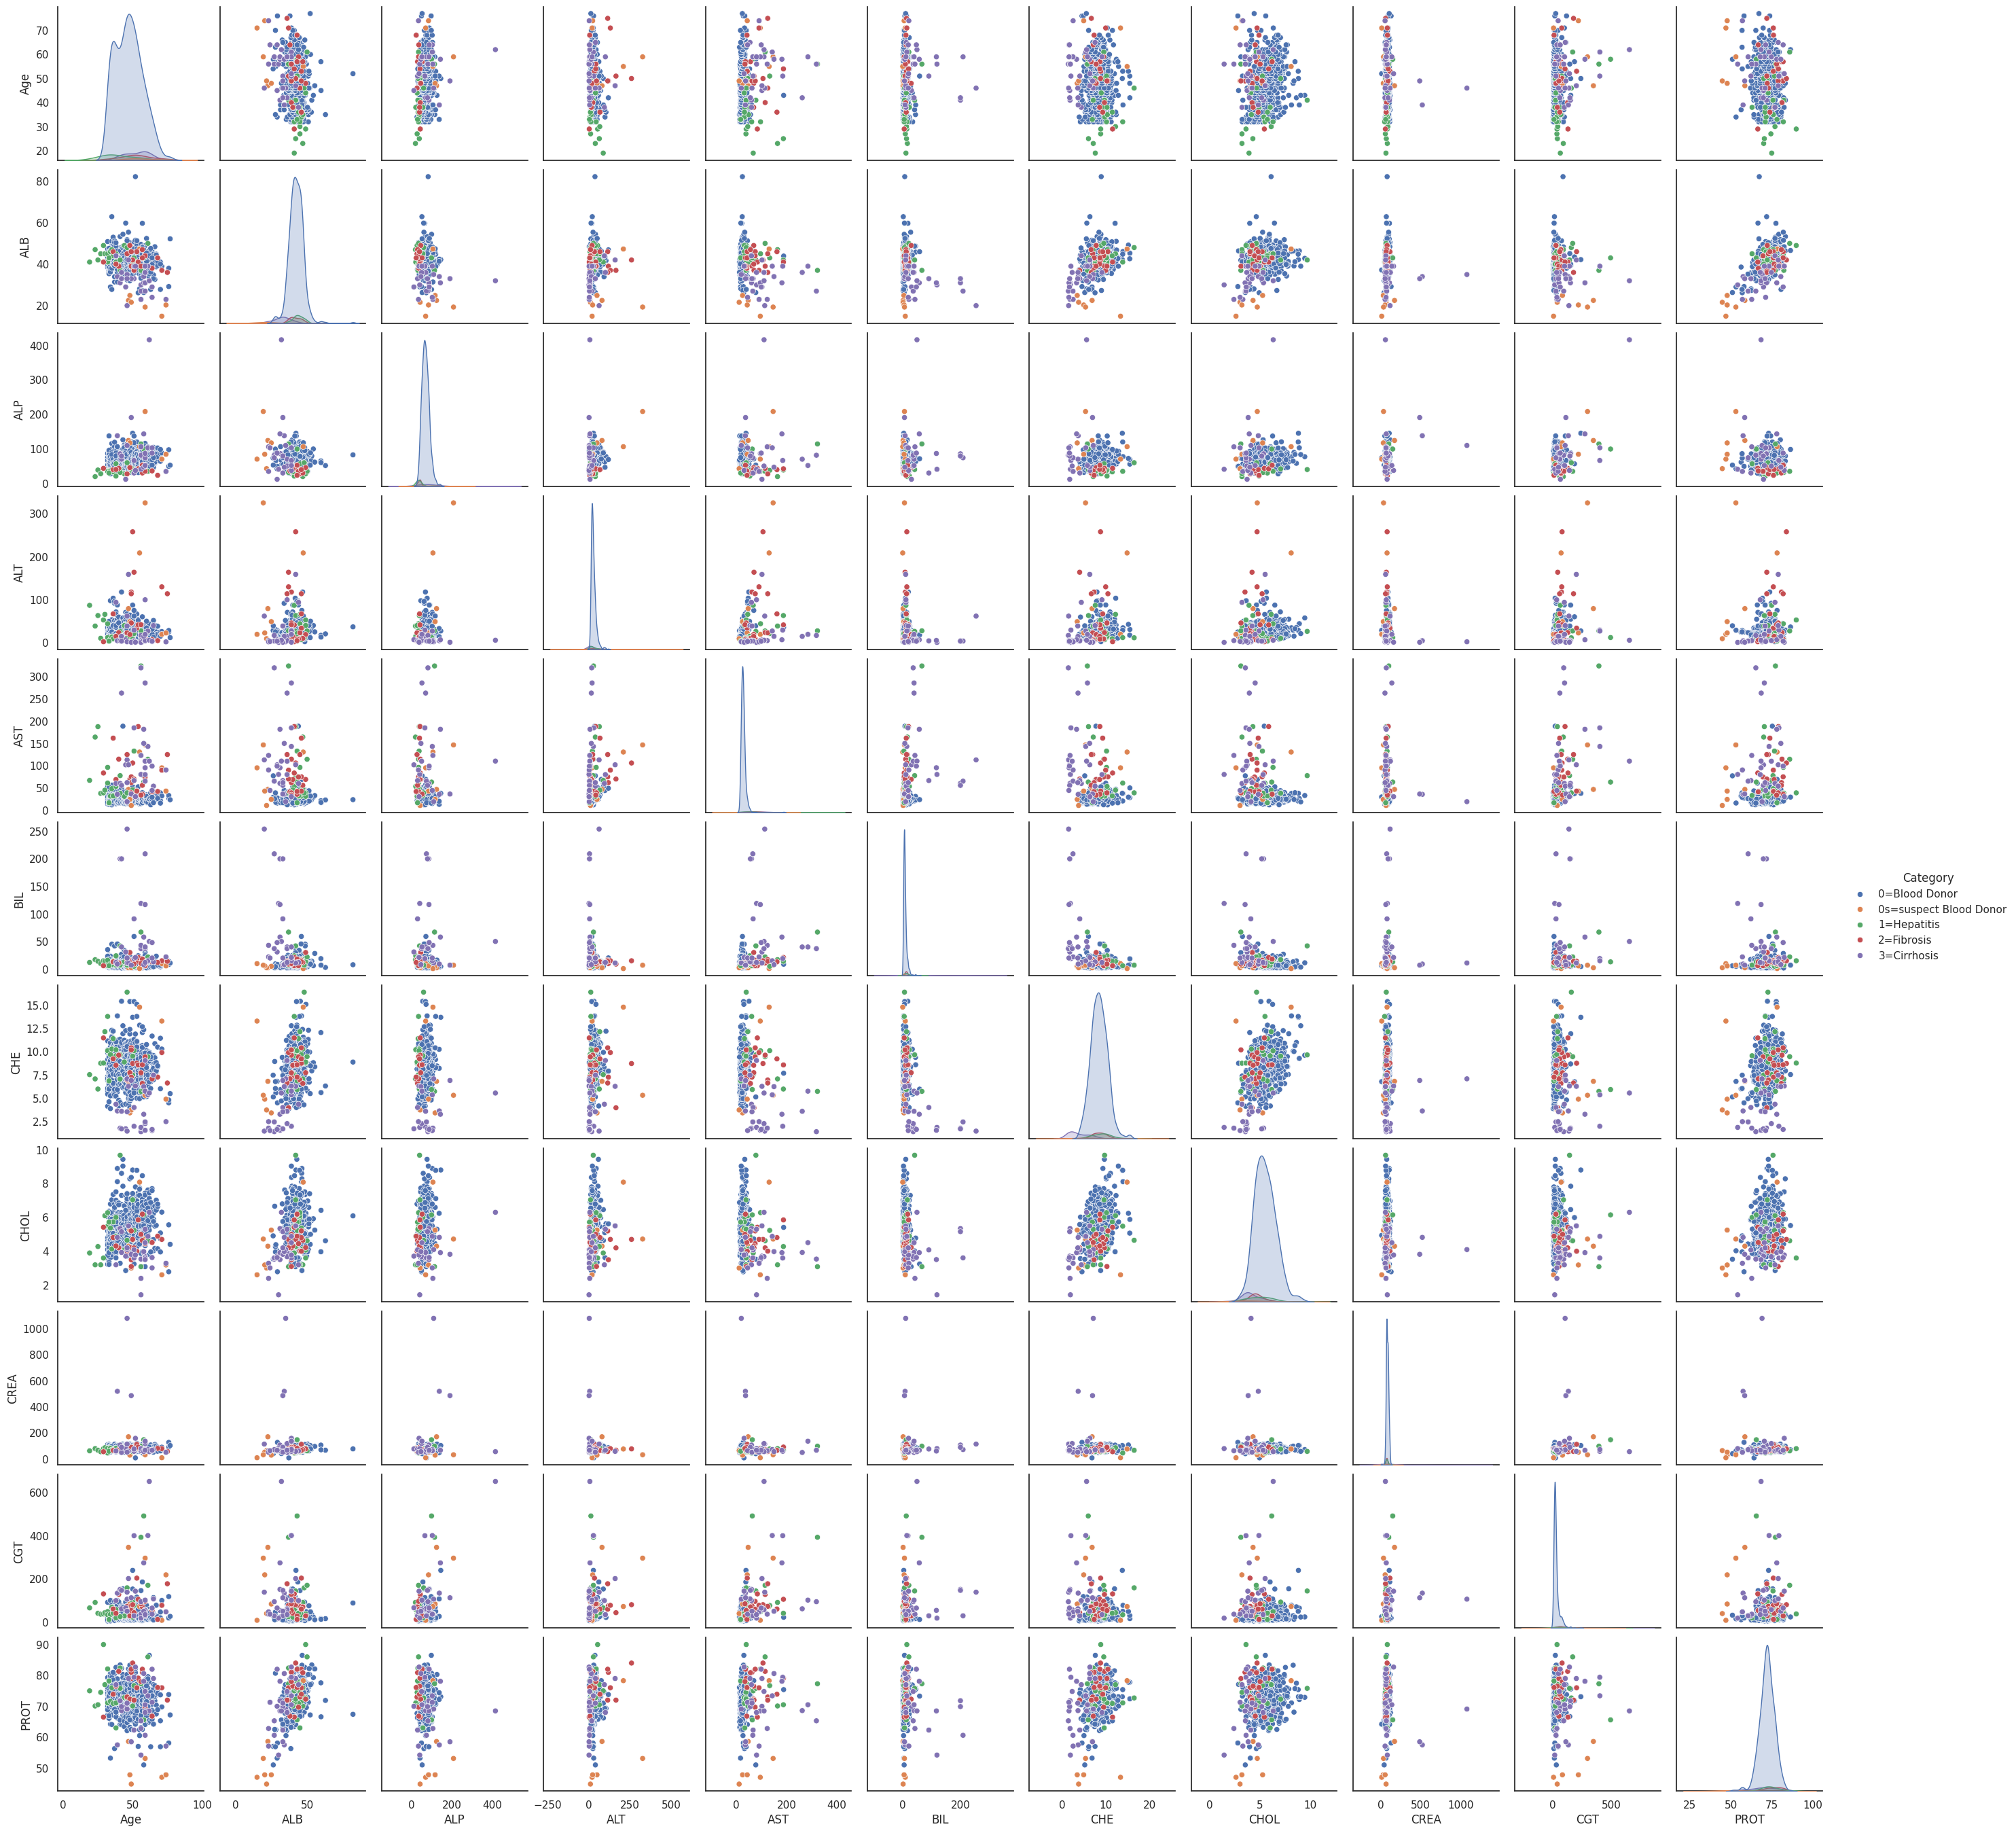

In [147]:
sns.pairplot(hcv, hue='Category')

# Data Preprocessing

In [148]:
hcv

Age Sex   ALB    ALP    ALT    AST   BIL    CHE  CHOL   CREA    CGT  \
0     32   m  38.5   52.5    7.7   22.1   7.5   6.93  3.23  106.0   12.1   
1     32   m  38.5   70.3   18.0   24.7   3.9  11.17  4.80   74.0   15.6   
2     32   m  46.9   74.7   36.2   52.6   6.1   8.84  5.20   86.0   33.2   
3     32   m  43.2   52.0   30.6   22.6  18.9   7.33  4.74   80.0   33.8   
4     32   m  39.2   74.1   32.6   24.8   9.6   9.15  4.32   76.0   29.9   
..   ...  ..   ...    ...    ...    ...   ...    ...   ...    ...    ...   
610   62   f  32.0  416.6    5.9  110.3  50.0   5.57  6.30   55.7  650.9   
611   64   f  24.0  102.8    2.9   44.4  20.0   1.54  3.02   63.0   35.9   
612   64   f  29.0   87.3    3.5   99.0  48.0   1.66  3.63   66.7   64.2   
613   46   f  33.0    NaN   39.0   62.0  20.0   3.56  4.20   52.0   50.0   
614   59   f  36.0    NaN  100.0   80.0  12.0   9.07  5.30   67.0   34.0   

     PROT       Category  
0    69.0  0=Blood Donor  
1    76.5  0=Blood Donor  
2    79.3  0=Blood Donor  
3    75.7  0=Blood Donor  
4    68.7  0=Blood Donor  
..    ...            ...  
610  68.5    3=Cirrhosis  
611  71.3    3=Cirrhosis  
612  82.0    3=Cirrhosis  
613  71.0    3=Cirrhosis  
614  68.0    3=Cirrhosis  

[615 rows x 13 columns]

## Encoding

In [149]:
hcv.Category.value_counts()

Category
0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: count, dtype: int64

In [150]:
#Encoding 'safe' blood donors as 0, and 'unsafe' (includes suspected cases) as 1.
hcv_encoded = hcv
hcv_encoded['Category'] = hcv_encoded['Category'].apply(lambda x: 0 if x == '0=Blood Donor' else 1)

In [151]:
hcv_encoded.Category.value_counts()

Category
0    533
1     82
Name: count, dtype: int64

In [152]:
hcv_encoded = encode_categorical(hcv_encoded)
hcv_encoded

Encoded 'Sex': ['m' 'f'] -> [1 0]


Age  Sex   ALB    ALP    ALT    AST   BIL    CHE  CHOL   CREA    CGT  \
0     32    1  38.5   52.5    7.7   22.1   7.5   6.93  3.23  106.0   12.1   
1     32    1  38.5   70.3   18.0   24.7   3.9  11.17  4.80   74.0   15.6   
2     32    1  46.9   74.7   36.2   52.6   6.1   8.84  5.20   86.0   33.2   
3     32    1  43.2   52.0   30.6   22.6  18.9   7.33  4.74   80.0   33.8   
4     32    1  39.2   74.1   32.6   24.8   9.6   9.15  4.32   76.0   29.9   
..   ...  ...   ...    ...    ...    ...   ...    ...   ...    ...    ...   
610   62    0  32.0  416.6    5.9  110.3  50.0   5.57  6.30   55.7  650.9   
611   64    0  24.0  102.8    2.9   44.4  20.0   1.54  3.02   63.0   35.9   
612   64    0  29.0   87.3    3.5   99.0  48.0   1.66  3.63   66.7   64.2   
613   46    0  33.0    NaN   39.0   62.0  20.0   3.56  4.20   52.0   50.0   
614   59    0  36.0    NaN  100.0   80.0  12.0   9.07  5.30   67.0   34.0   

     PROT  Category  
0    69.0         0  
1    76.5         0  
2    79.3         0  
3    75.7         0  
4    68.7         0  
..    ...       ...  
610  68.5         1  
611  71.3         1  
612  82.0         1  
613  71.0         1  
614  68.0         1  

[615 rows x 13 columns]

## Outlier check

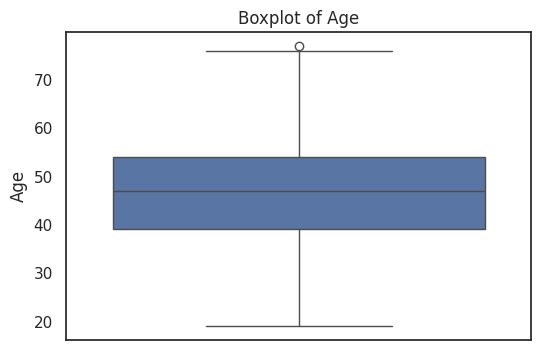

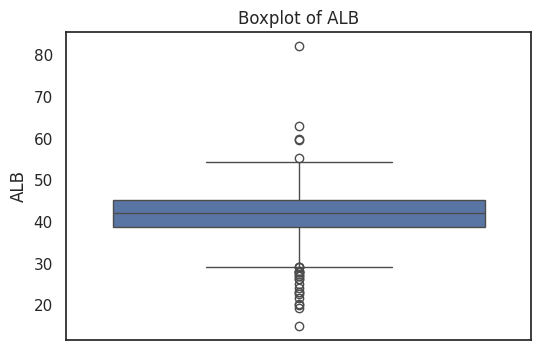

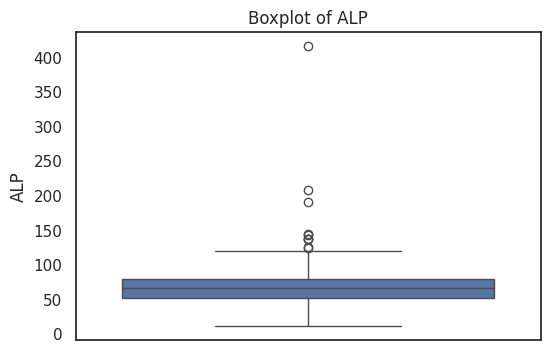

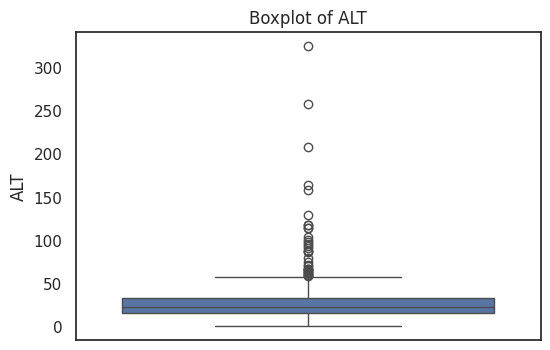

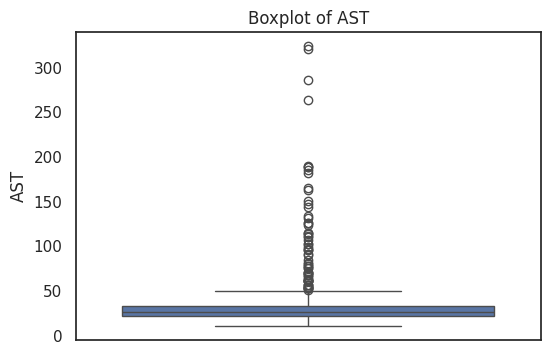

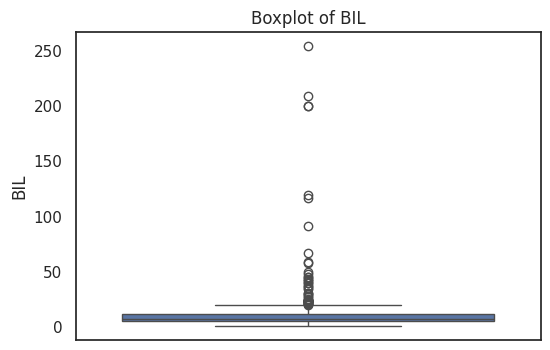

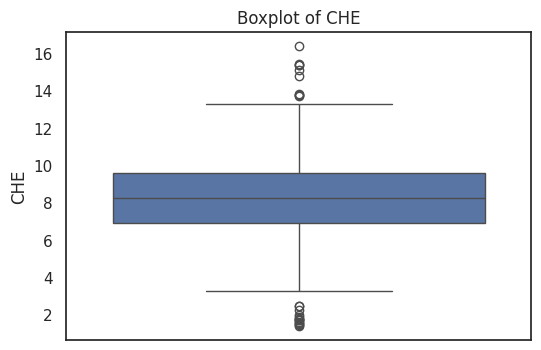

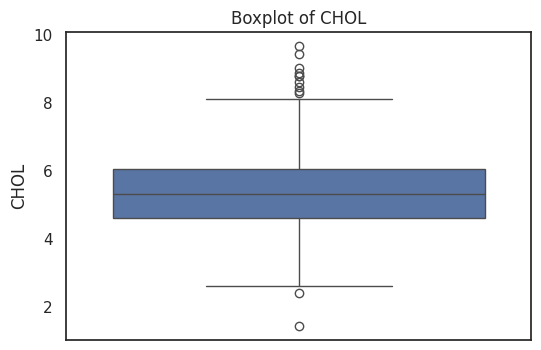

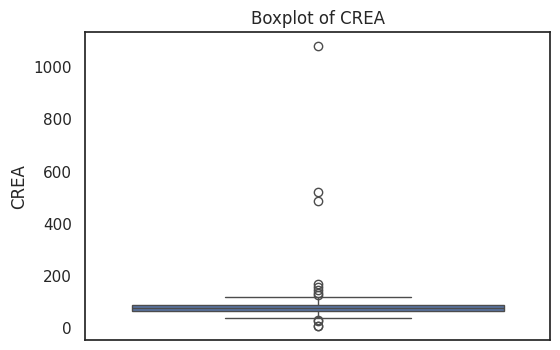

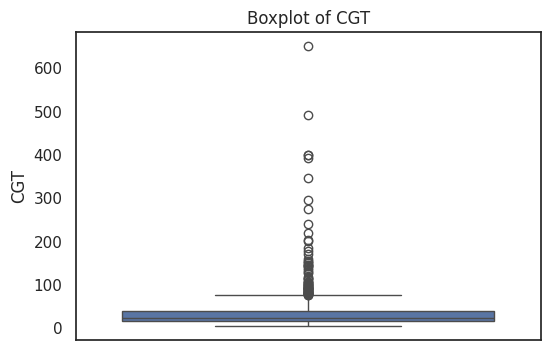

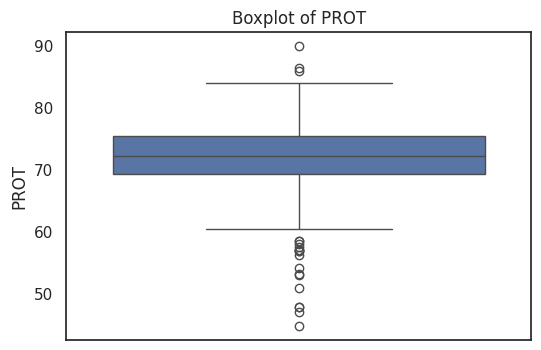

In [153]:
# Columns to exclude
exclude_cols = ['Sex', 'Category']

# Select numeric columns except excluded ones
numeric_cols = hcv_encoded.select_dtypes(include='number').columns.drop(exclude_cols)

# Plot each numeric column separately
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=hcv_encoded[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)  # Corresponding y-axis label
    plt.show()

In [154]:
numerical_cols = hcv_encoded.select_dtypes(include=np.number).columns
outlier_indices = {}

for col in numerical_cols:
    Q1 = hcv_encoded[col].quantile(0.25)
    Q3 = hcv_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    indices = hcv_encoded[(hcv_encoded[col] < lower_bound) | (hcv_encoded[col] > upper_bound)].index
    if len(indices) > 0:
            outlier_indices[col] = indices.tolist()
            #print(f'{len(indices)} outliers found in {col} column')
    else:
        pass
        #print(f"No outlier data found for column {col}")

outlier_values = []
outliers_count = 0
for col, rows in outlier_indices.items():
    outlier_values.append([col, len(rows), (len(rows)*100/ len(hcv_encoded[col]))]) #this was set to 10, should be 100
    outliers_count = outliers_count + 1 if len(rows) > 0 else outliers_count

if outliers_count > 0:
    data_outliers = pd.DataFrame(outlier_values)
    data_outliers.columns = ['Variable', 'Outliers', 'Percentage Outliers']
    s = data_outliers.sort_values(by=['Percentage Outliers'], ascending=False).style.bar(subset=['Percentage Outliers'], color='#d65f5f')
    display(s)
else:
    print('No outlier values found in the dataset.')

## Missing check

In [155]:
CheckNull = hcv_encoded.isnull().sum()
for var in range(0, len(CheckNull)):
    misVariables.append([hcv_encoded.columns[var], CheckNull[var], round(CheckNull[var]*100/len(hcv_encoded),3)]) #Same thing here, should be 100 not 10
    missing = missing + 1

if missing == 0:
    print('Dataset is complete with no blanks.')
else:
    data_misVariables = pd.DataFrame.from_records(misVariables)
    data_misVariables.columns = ['Variable', 'Missing', 'Percentage missing']
    s = data_misVariables.sort_values(by=['Percentage missing'], ascending=False).style.bar(subset=['Percentage missing'], color='#d65f5f')
    display(s)

## Imputation

In [156]:
hcv_dropped = drop_high_missing_cols(hcv_encoded, threshold=0.50)
"""hcv_knn_predicted= knn_impute(hcv_dropped, min_thresh=0.02, max_thresh=0.50, n_neighbors=5)
hcv_imputed = impute_simple_central(hcv_knn_predicted, max_thresh=0.05)"""

--- Running Step 1: Dropping columns > 50% missing ---
   -> No columns exceeded the missing value threshold.


'hcv_knn_predicted= knn_impute(hcv_dropped, min_thresh=0.02, max_thresh=0.50, n_neighbors=5)\nhcv_imputed = impute_simple_central(hcv_knn_predicted, max_thresh=0.05)'

In [157]:
#Split data to avoid data leakage
from sklearn.model_selection import train_test_split

TARGET_COL = 'Category'

X = hcv_encoded.drop(columns=[TARGET_COL])   # all columns except 'stroke'
y = hcv_encoded[TARGET_COL]                # the target column

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3003)
print("Train predictors shape:", X_train.shape)
print("Test predictors shape:", X_test.shape)
print("Train target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Train predictors shape: (492, 12)
Test predictors shape: (123, 12)
Train target shape: (492,)
Test target shape: (123,)


In [158]:
def check_missing(df):
    # Step 1: Get the count of missing values for each column
    CheckNull = df.isnull().sum()  # This returns a Series where each column's name is mapped to the number of missing values

    # Step 2: Create a list of tuples that store:
    # - The column name
    # - The number of missing values
    # - The percentage of missing values (calculated as missing values / total rows)
    # Changed the approach here to use list comprehension for cleaner and more concise code.
    misVariables = [(column, CheckNull[column], round(CheckNull[column] / len(df), 3))
                    for column in df.columns]  # List comprehension to gather column names, missing values, and percentages
    # This change makes the code more efficient and avoids the need for a separate for loop.

    # Step 3: Calculate how many variables (columns) have missing values
    missing = sum(1 for var in CheckNull if var > 0)  # Count how many columns have missing values (any non-zero value)
    # The original code was trying to update the 'missing' variable inside the loop, which was incorrect.
    # This revised line counts columns with any missing values more efficiently.
    # Step 5: Create a DataFrame to show the missing value details for each column
    df_misVariables = pd.DataFrame(misVariables, columns=['Variable', 'Missing', 'Percentage'])

    # Step 4: Print message based on whether there are missing values or not
    if missing == 0:
        print('Dataset is complete with no blanks.')  # If no missing values in any column, inform the user
    else:

        # Step 6: Sort the DataFrame by the 'Percentage' column in descending order
        # so the columns with the highest percentage of missing data appear first.
        s = df_misVariables.sort_values(by=['Percentage'], ascending=False).style.bar(subset=['Percentage'], color='#d65f5f')
        # Added the sorting step explicitly to make sure that columns with the most missing values are displayed first.
        # Using .style.bar helps visualize missing values better by adding a color gradient to the percentages.

        # Step 7: Display the DataFrame with missing value statistics (works in Jupyter Notebooks or environments supporting display())
        display(s)  # This will work in Jupyter, but you can replace this with print() if running outside Jupyter
        # 'display' is used for environments like Jupyter Notebooks. If using standard Python, this should be replaced with 'print()'.

    return df_misVariables  # Return the DataFrame that contains missing value statistics

# Step 8: Call the function to check missing values in the training data (X_train)
print("Only for predictors from training dataset!")
ranked_df_missing_value = check_missing(X_train)

Only for predictors from training dataset!


In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer

In [160]:
#Simple imputation for columns with less than 0.02 (2%) missingnes
#make working copies so originals stay intact --> use next X_train_simple and X_test_simple
X_train_simple = X_train.copy()
X_test_simple  = X_test.copy()

#choose the column name to impute
COL_IMP = "CHOL"

#safety checks
if COL_IMP not in X_train_simple.columns:
    raise KeyError(f"Column '{COL_IMP}' not found in X_train_simple. Available: {list(X_train_simple.columns)[:10]} ...")

#simple imputer for numeric BMI
CHOL_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# fit on TRAIN only
CHOL_imputer.fit(X_train_simple[[COL_IMP]])

# apply to train & test
X_train_simple.loc[:, COL_IMP] = CHOL_imputer.transform(X_train_simple[[COL_IMP]])
X_test_simple.loc[:,  COL_IMP] = CHOL_imputer.transform(X_test_simple[[COL_IMP]])

# what value did we use?
filled_value = float(CHOL_imputer.statistics_[0])
print(f"BMI imputed with {CHOL_imputer.strategy}: {filled_value:.4f}")

# quick checks
print("Missing in TRAIN after simple imputation:", X_train_simple[COL_IMP].isna().sum())
print("Missing in TEST  after simple imputation:",  X_test_simple[COL_IMP].isna().sum())

BMI imputed with median: 5.3000
Missing in TRAIN after simple imputation: 0
Missing in TEST  after simple imputation: 0


In [161]:
#choose the column name to impute
COL_IMP = "PROT"

#safety checks
if COL_IMP not in X_train_simple.columns:
    raise KeyError(f"Column '{COL_IMP}' not found in X_train_simple. Available: {list(X_train_simple.columns)[:10]} ...")

#simple imputer for numeric BMI
PROT_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# fit on TRAIN only
PROT_imputer.fit(X_train_simple[[COL_IMP]])

# apply to train & test
X_train_simple.loc[:, COL_IMP] = PROT_imputer.transform(X_train_simple[[COL_IMP]])
X_test_simple.loc[:,  COL_IMP] = PROT_imputer.transform(X_test_simple[[COL_IMP]])

# what value did we use?
filled_value = float(PROT_imputer.statistics_[0])
print(f"BMI imputed with {PROT_imputer.strategy}: {filled_value:.4f}")

# quick checks
print("Missing in TRAIN after simple imputation:", X_train_simple[COL_IMP].isna().sum())
print("Missing in TEST  after simple imputation:",  X_test_simple[COL_IMP].isna().sum())

BMI imputed with median: 72.3000
Missing in TRAIN after simple imputation: 0
Missing in TEST  after simple imputation: 0


In [162]:
#choose the column name to impute
COL_IMP = "ALB"

#safety checks
if COL_IMP not in X_train_simple.columns:
    raise KeyError(f"Column '{COL_IMP}' not found in X_train_simple. Available: {list(X_train_simple.columns)[:10]} ...")

#simple imputer for numeric BMI
ALB_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# fit on TRAIN only
ALB_imputer.fit(X_train_simple[[COL_IMP]])

# apply to train & test
X_train_simple.loc[:, COL_IMP] = ALB_imputer.transform(X_train_simple[[COL_IMP]])
X_test_simple.loc[:,  COL_IMP] = ALB_imputer.transform(X_test_simple[[COL_IMP]])

# what value did we use?
filled_value = float(ALB_imputer.statistics_[0])
print(f"BMI imputed with {ALB_imputer.strategy}: {filled_value:.4f}")

# quick checks
print("Missing in TRAIN after simple imputation:", X_train_simple[COL_IMP].isna().sum())
print("Missing in TEST  after simple imputation:",  X_test_simple[COL_IMP].isna().sum())

BMI imputed with median: 42.0000
Missing in TRAIN after simple imputation: 0
Missing in TEST  after simple imputation: 0


In [163]:
#choose the column name to impute
COL_IMP = "ALT"

#safety checks
if COL_IMP not in X_train_simple.columns:
    raise KeyError(f"Column '{COL_IMP}' not found in X_train_simple. Available: {list(X_train_simple.columns)[:10]} ...")

#simple imputer for numeric BMI
ALT_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# fit on TRAIN only
ALT_imputer.fit(X_train_simple[[COL_IMP]])

# apply to train & test
X_train_simple.loc[:, COL_IMP] = ALT_imputer.transform(X_train_simple[[COL_IMP]])
X_test_simple.loc[:,  COL_IMP] = ALT_imputer.transform(X_test_simple[[COL_IMP]])

# what value did we use?
filled_value = float(ALT_imputer.statistics_[0])
print(f"BMI imputed with {ALT_imputer.strategy}: {filled_value:.4f}")

# quick checks
print("Missing in TRAIN after simple imputation:", X_train_simple[COL_IMP].isna().sum())
print("Missing in TEST  after simple imputation:",  X_test_simple[COL_IMP].isna().sum())

BMI imputed with median: 23.2000
Missing in TRAIN after simple imputation: 0
Missing in TEST  after simple imputation: 0


In [164]:
ranked_df_missing_value = check_missing(X_train_simple) #only ALP is left, since it is more than 2% missingness --> we will impute it using KNN imputer

In [165]:
#Define which numeric columns have missings
num_miss = ['ALP']

X_train_imputed = X_train_simple.copy()
X_test_imputed = X_test_simple.copy()

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")

#Fit on TRAIN, transform both TRAIN and TEST
X_train_imputed[num_miss] = knn_imputer.fit_transform(X_train_imputed[num_miss])
X_test_imputed[num_miss] = knn_imputer.transform(X_test_imputed[num_miss])

# Check results
print("After KNN imputation - train missing:", X_train_imputed.isna().sum().sum())
print("After KNN imputation - test  missing:", X_test_imputed.isna().sum().sum())

After KNN imputation - train missing: 0
After KNN imputation - test  missing: 0


In [166]:
ranked_df_missing_value = check_missing(X_train_imputed) #only ALP is left, since it is more than 2% missingness --> we will impute it using KNN imputer

Dataset is complete with no blanks.


In [167]:
X_train_imputed

Age  Sex   ALB   ALP   ALT    AST   BIL    CHE  CHOL   CREA   CGT  PROT
72    38    1  45.5  50.2  16.3   22.8  10.9   8.73  5.88  103.0  13.8  76.1
261   57    1  43.3  86.8  21.2   22.2   6.8   7.87  4.91   65.0  19.2  71.3
379   43    0  37.6  77.1   8.3   15.9  12.5   8.37  4.49   73.0  68.9  67.1
115   42    1  37.8  83.7  25.3   20.0  18.6   7.52  5.07  108.0  17.4  64.1
122   43    1  42.9  50.7  26.4   22.0   6.4  10.20  4.72   81.0  15.2  71.8
..   ...  ...   ...   ...   ...    ...   ...    ...   ...    ...   ...   ...
169   47    1  46.2  63.0   7.0   17.4   6.5   7.06  5.23   60.0  26.6  75.4
136   44    1  47.3  43.9  16.2   19.3   4.7  10.02  5.85  100.0  14.9  71.2
393   44    0  35.8  65.7  21.2   19.2   4.3  10.19  6.13   61.0  19.6  69.4
566   46    1  45.0  26.9  23.1  125.0  17.0   6.97  4.01   60.5  72.2  73.0
70    38    1  48.1  63.2  11.7   14.7   5.1   8.83  3.87   85.0   9.5  73.1

[492 rows x 12 columns]

In [168]:
y_train.isnull().sum()

np.int64(0)

In [169]:
y_test.isnull().sum()

np.int64(0)

In [170]:
X_train_imputed.isnull().sum()

Age     0
Sex     0
ALB     0
ALP     0
ALT     0
AST     0
BIL     0
CHE     0
CHOL    0
CREA    0
CGT     0
PROT    0
dtype: int64

In [171]:
X_test_imputed.isnull().sum()

Age     0
Sex     0
ALB     0
ALP     0
ALT     0
AST     0
BIL     0
CHE     0
CHOL    0
CREA    0
CGT     0
PROT    0
dtype: int64

--> no missing values anymore

Correlation BEFORE imputation:


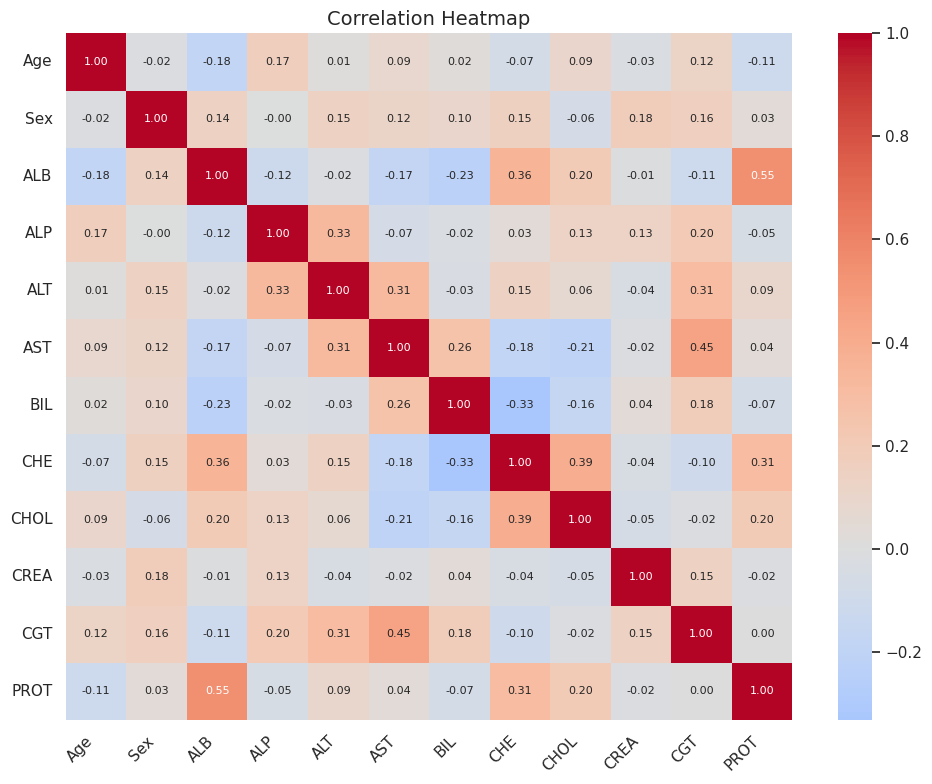

Correlation AFTER Simple Imputation:


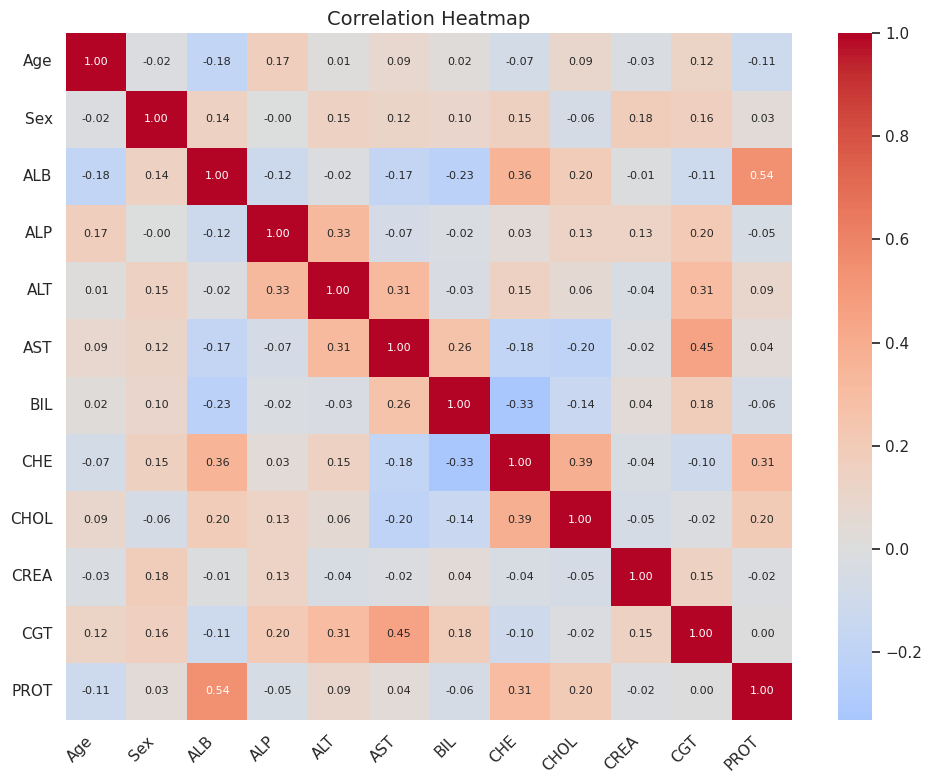

Correlation AFTER KNN Imputation:


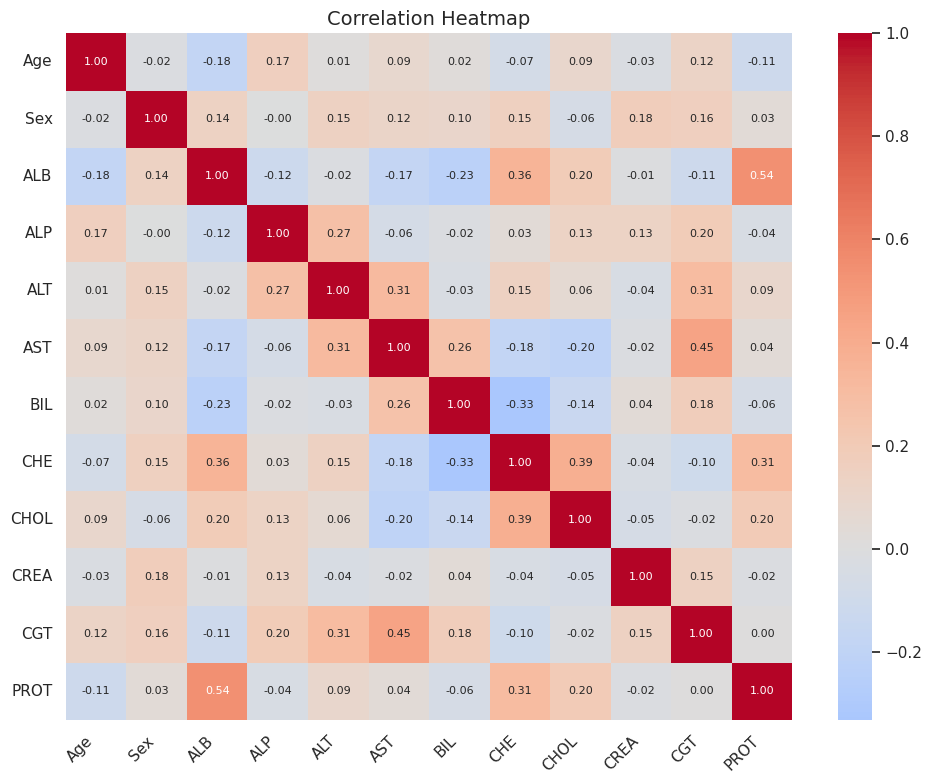

In [172]:
#check impact of imputation
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot correlations with readable numbers
def corr_plot(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(
        df.corr(),
        annot=True,           # Show correlation coefficients
        fmt=".2f",            # Format numbers to 2 decimal places
        cmap='coolwarm',
        center=0,
        annot_kws={"size": 8} # Control text size inside cells
    )
    plt.title("Correlation Heatmap", fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Choose numeric columns to visualize correlations
#first_30_columns = num_cols  # or a subset, e.g., num_cols[:30]

# Correlation before imputation
print("Correlation BEFORE imputation:")
corr_plot(X_train)

# Correlation after Simple Imputation
print("Correlation AFTER Simple Imputation:")
corr_plot(X_train_simple)

# Correlation after KNN imputation
print("Correlation AFTER KNN Imputation:")
corr_plot(X_train_imputed)

## Normalisation

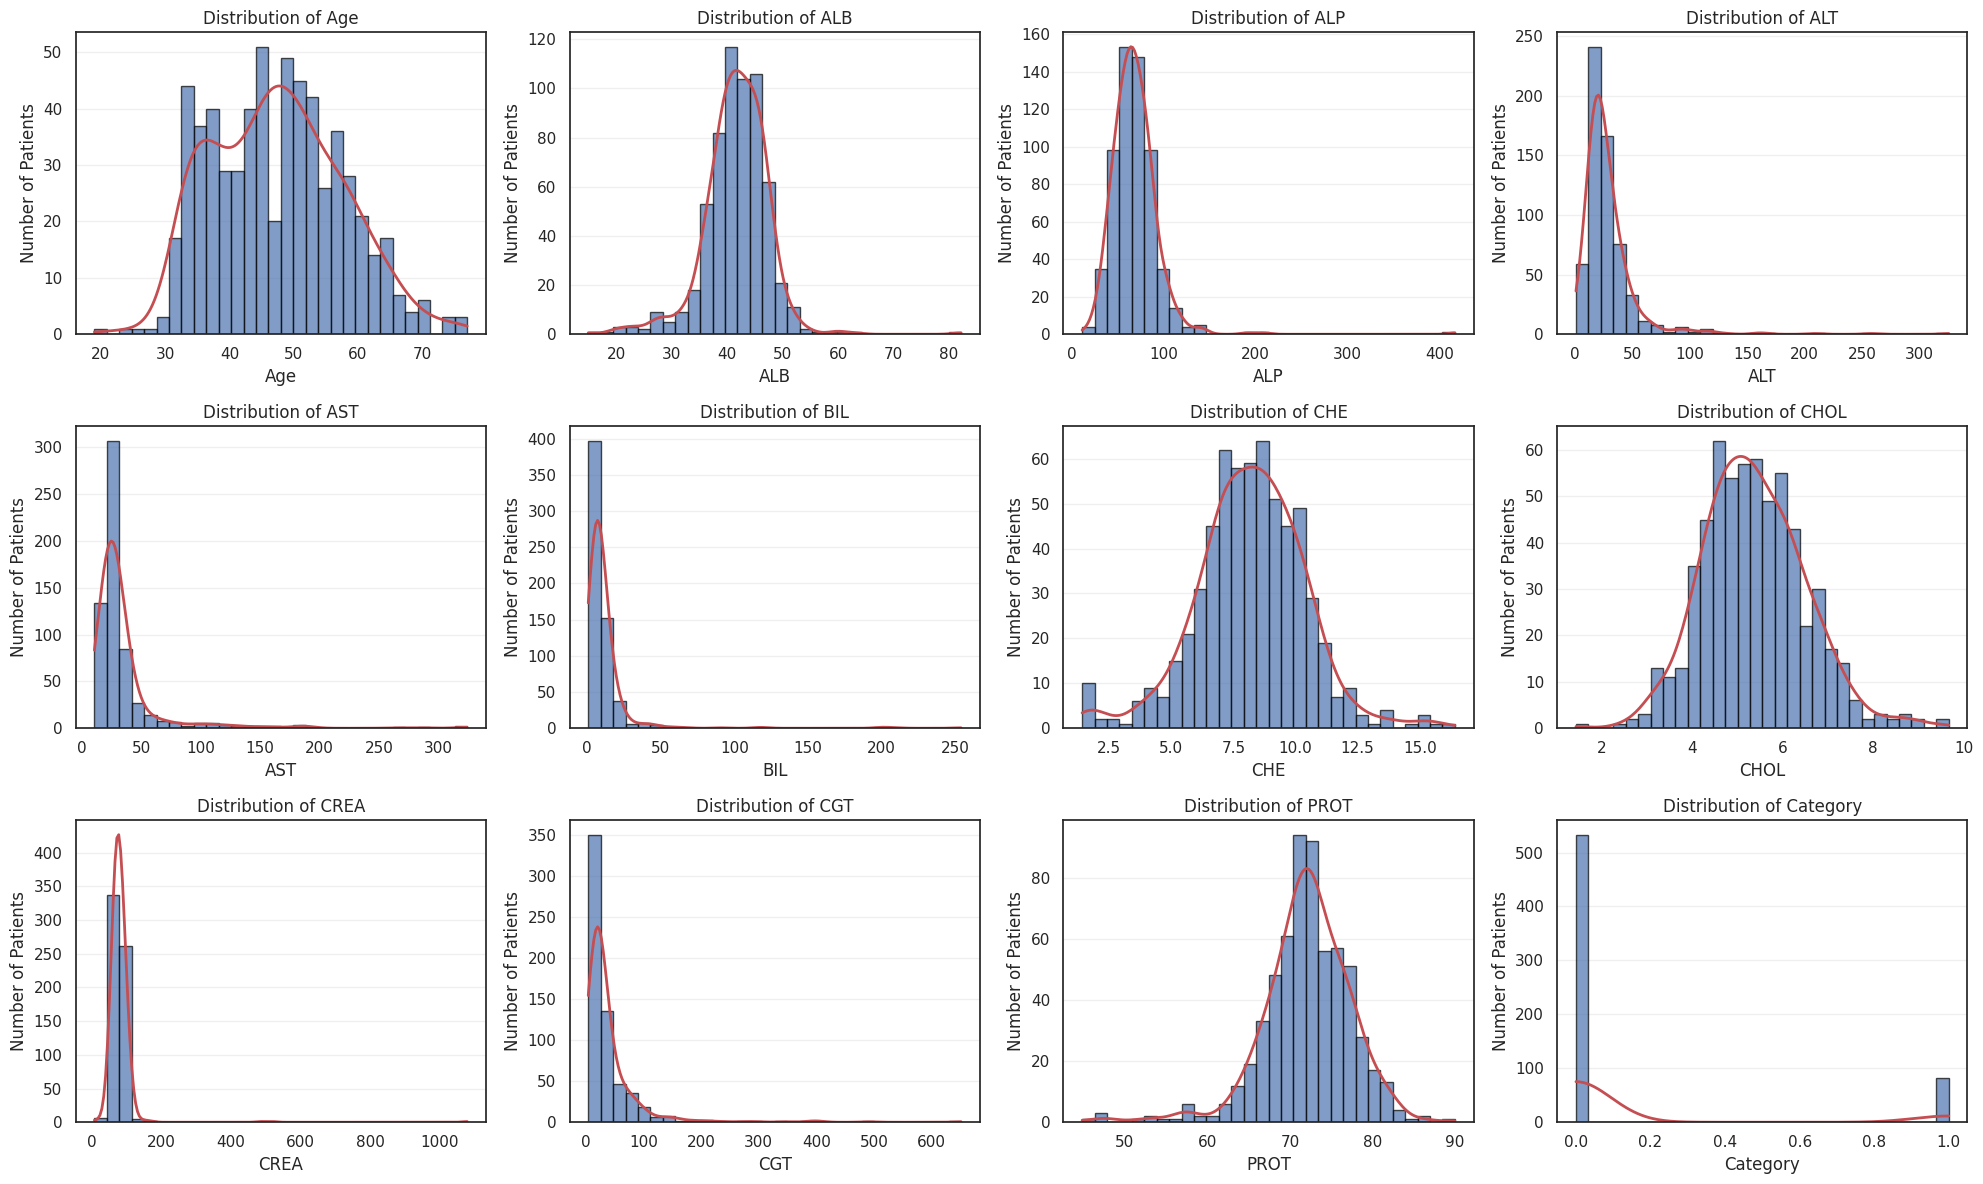

In [173]:
distplots(hcv)

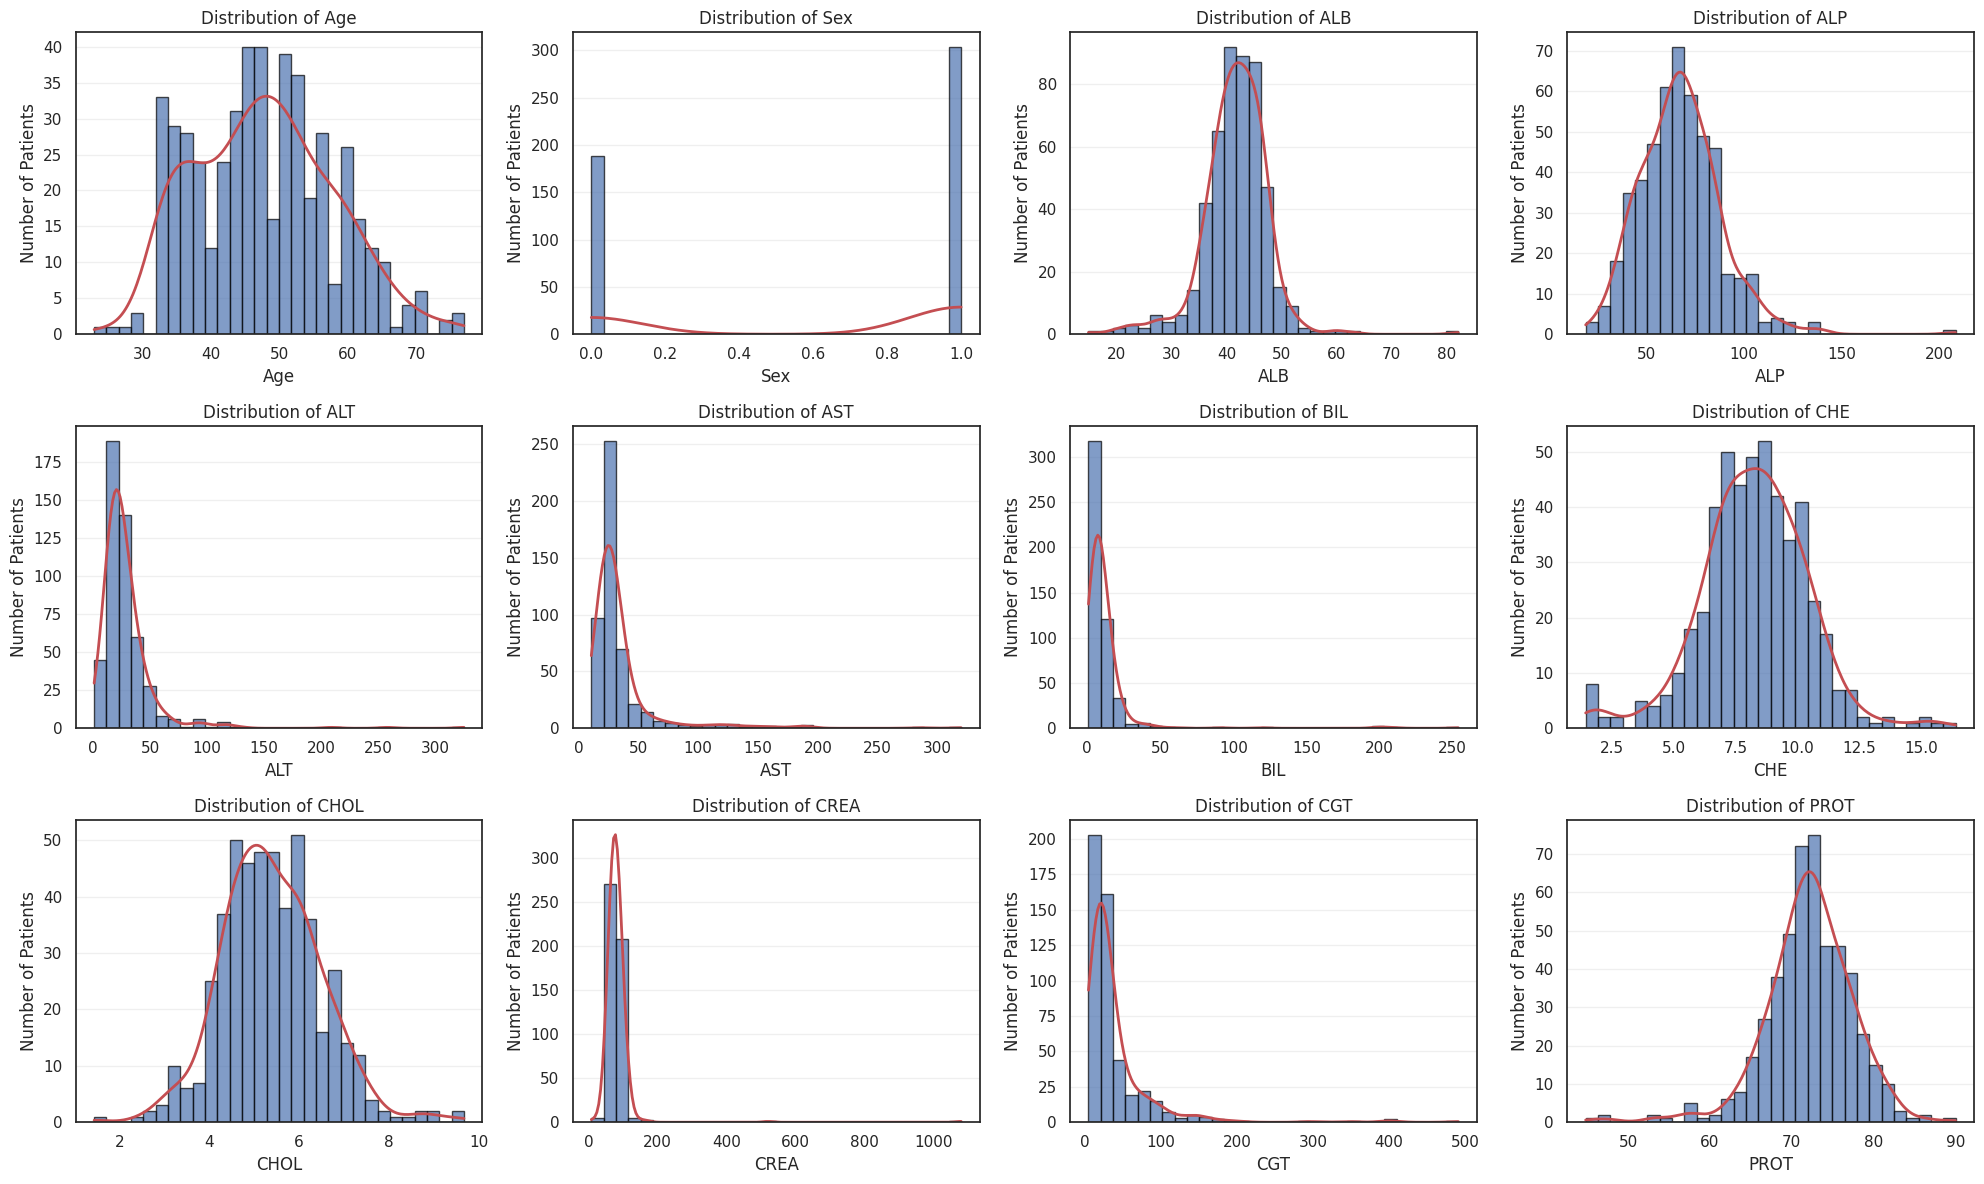

In [174]:
distplots(X_train_imputed)

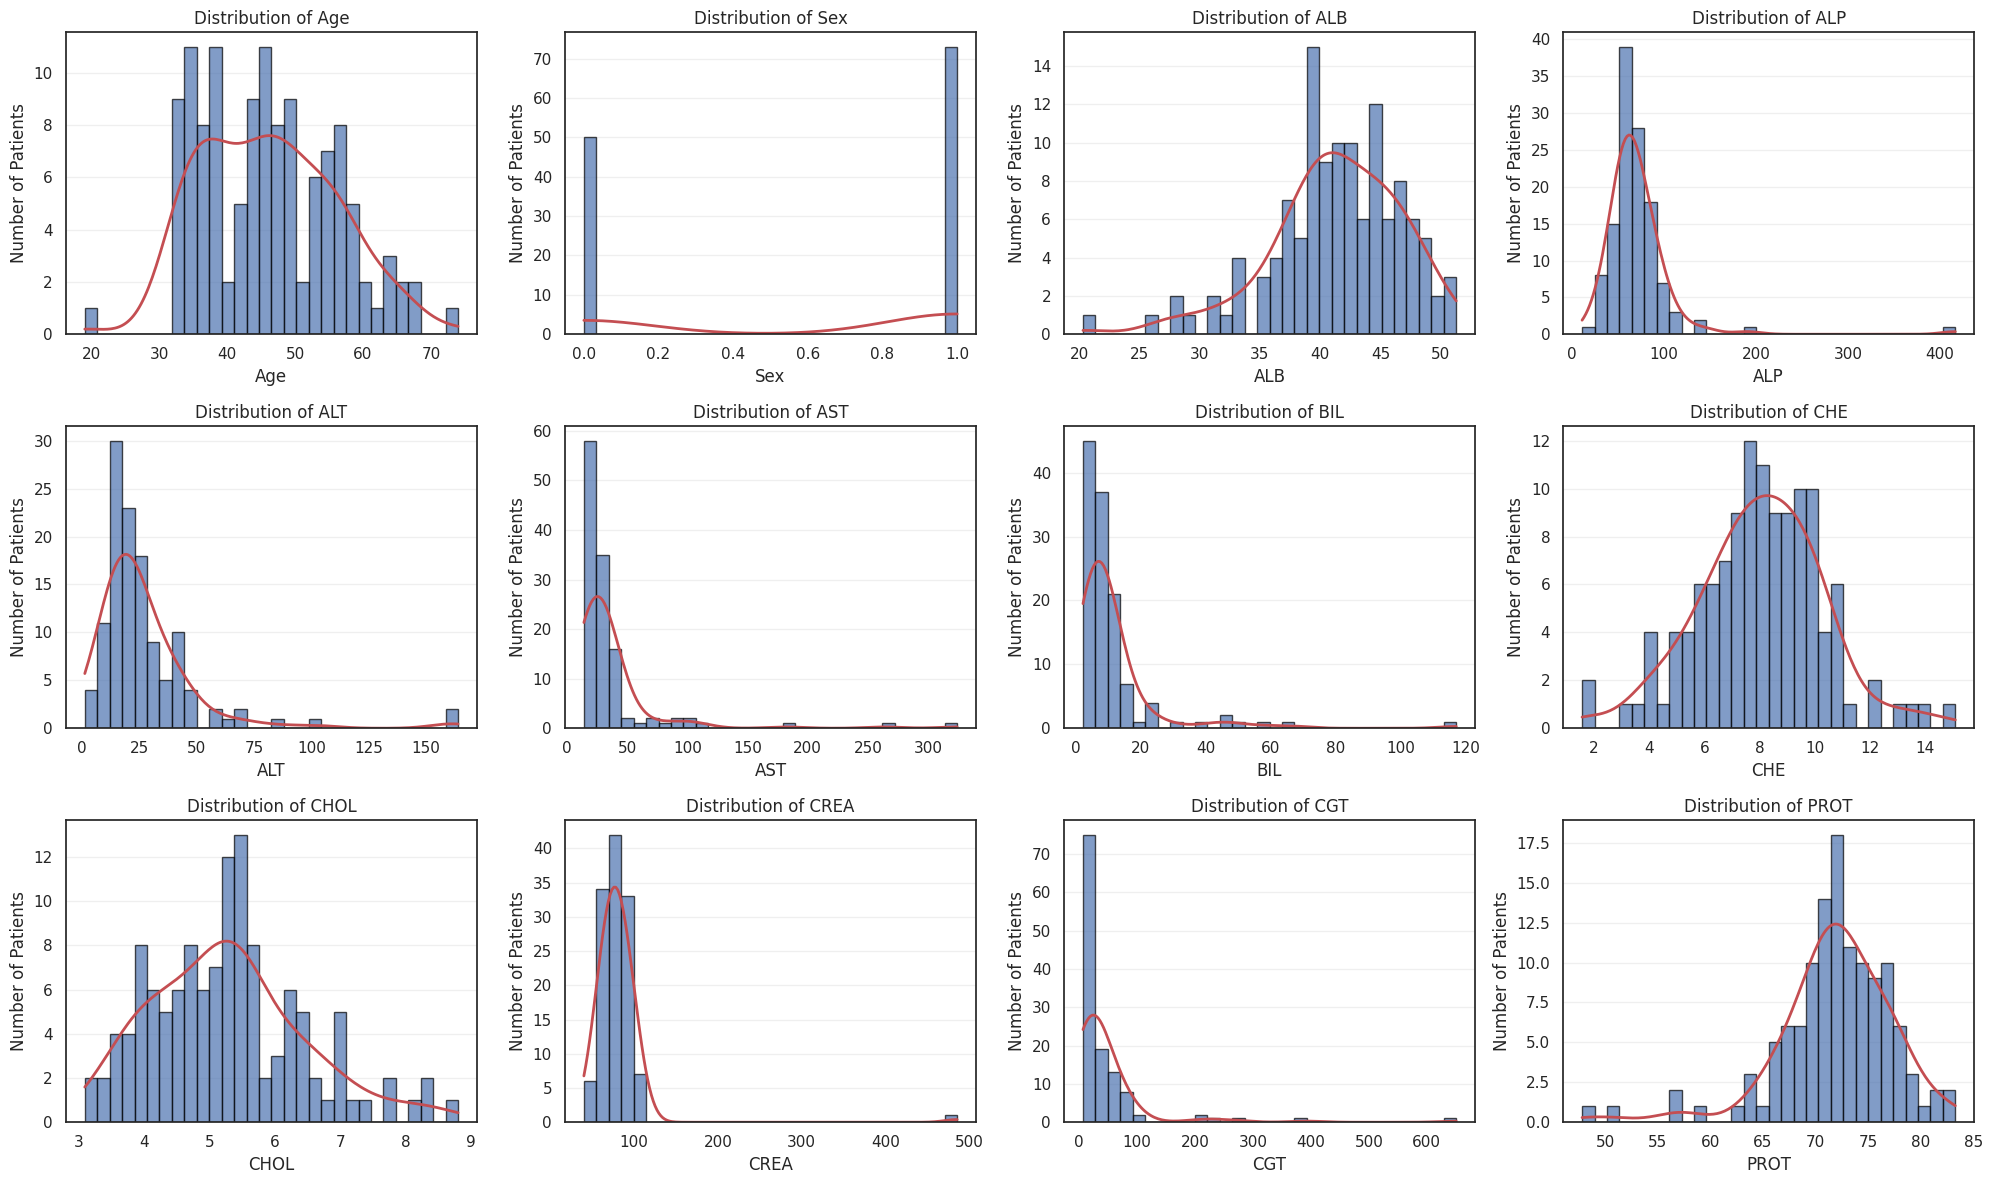

In [175]:
distplots(X_test_imputed)

In [176]:
"""hcv_normalized = normality_check_and_fix(hcv_imputed.drop(columns=['Category','Sex'])).join(hcv_imputed[['Category', 'Sex']])"""

"hcv_normalized = normality_check_and_fix(hcv_imputed.drop(columns=['Category','Sex'])).join(hcv_imputed[['Category', 'Sex']])"

In [177]:
#apply tranformation to skewed variables
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer

# Copy your datasets
X_train_log = X_train_imputed.copy()
X_test_log = X_test_imputed.copy()

# List of skewed columns to log-transform
skewed_cols = ['ALP', 'ALT', 'AST', 'BIL', 'CREA', 'CGT']

# Define log1p transformer
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Apply log transformation
X_train_log[skewed_cols] = log_transformer.fit_transform(X_train_log[skewed_cols])
X_test_log[skewed_cols] = log_transformer.transform(X_test_log[skewed_cols])

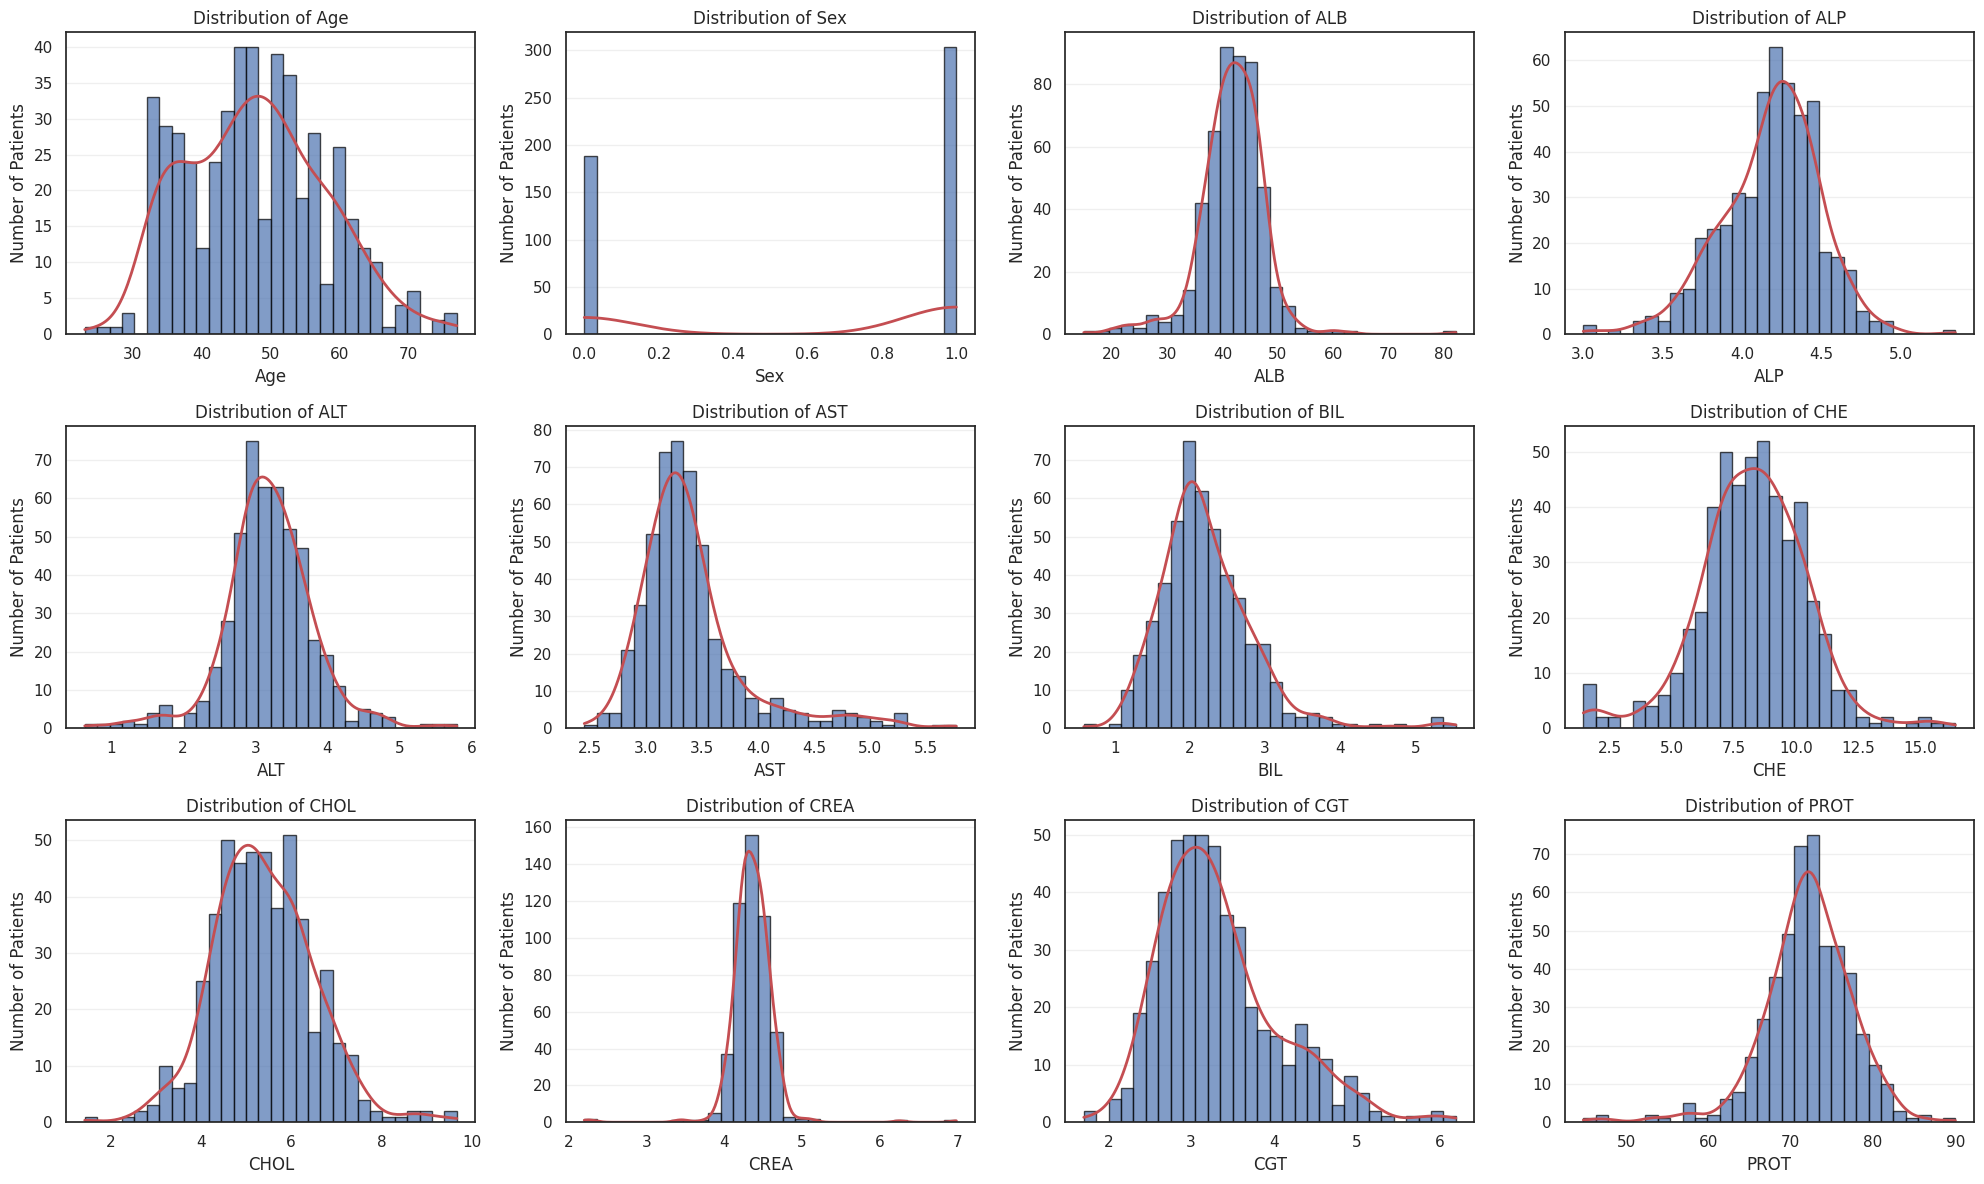

In [178]:
distplots(X_train_log)

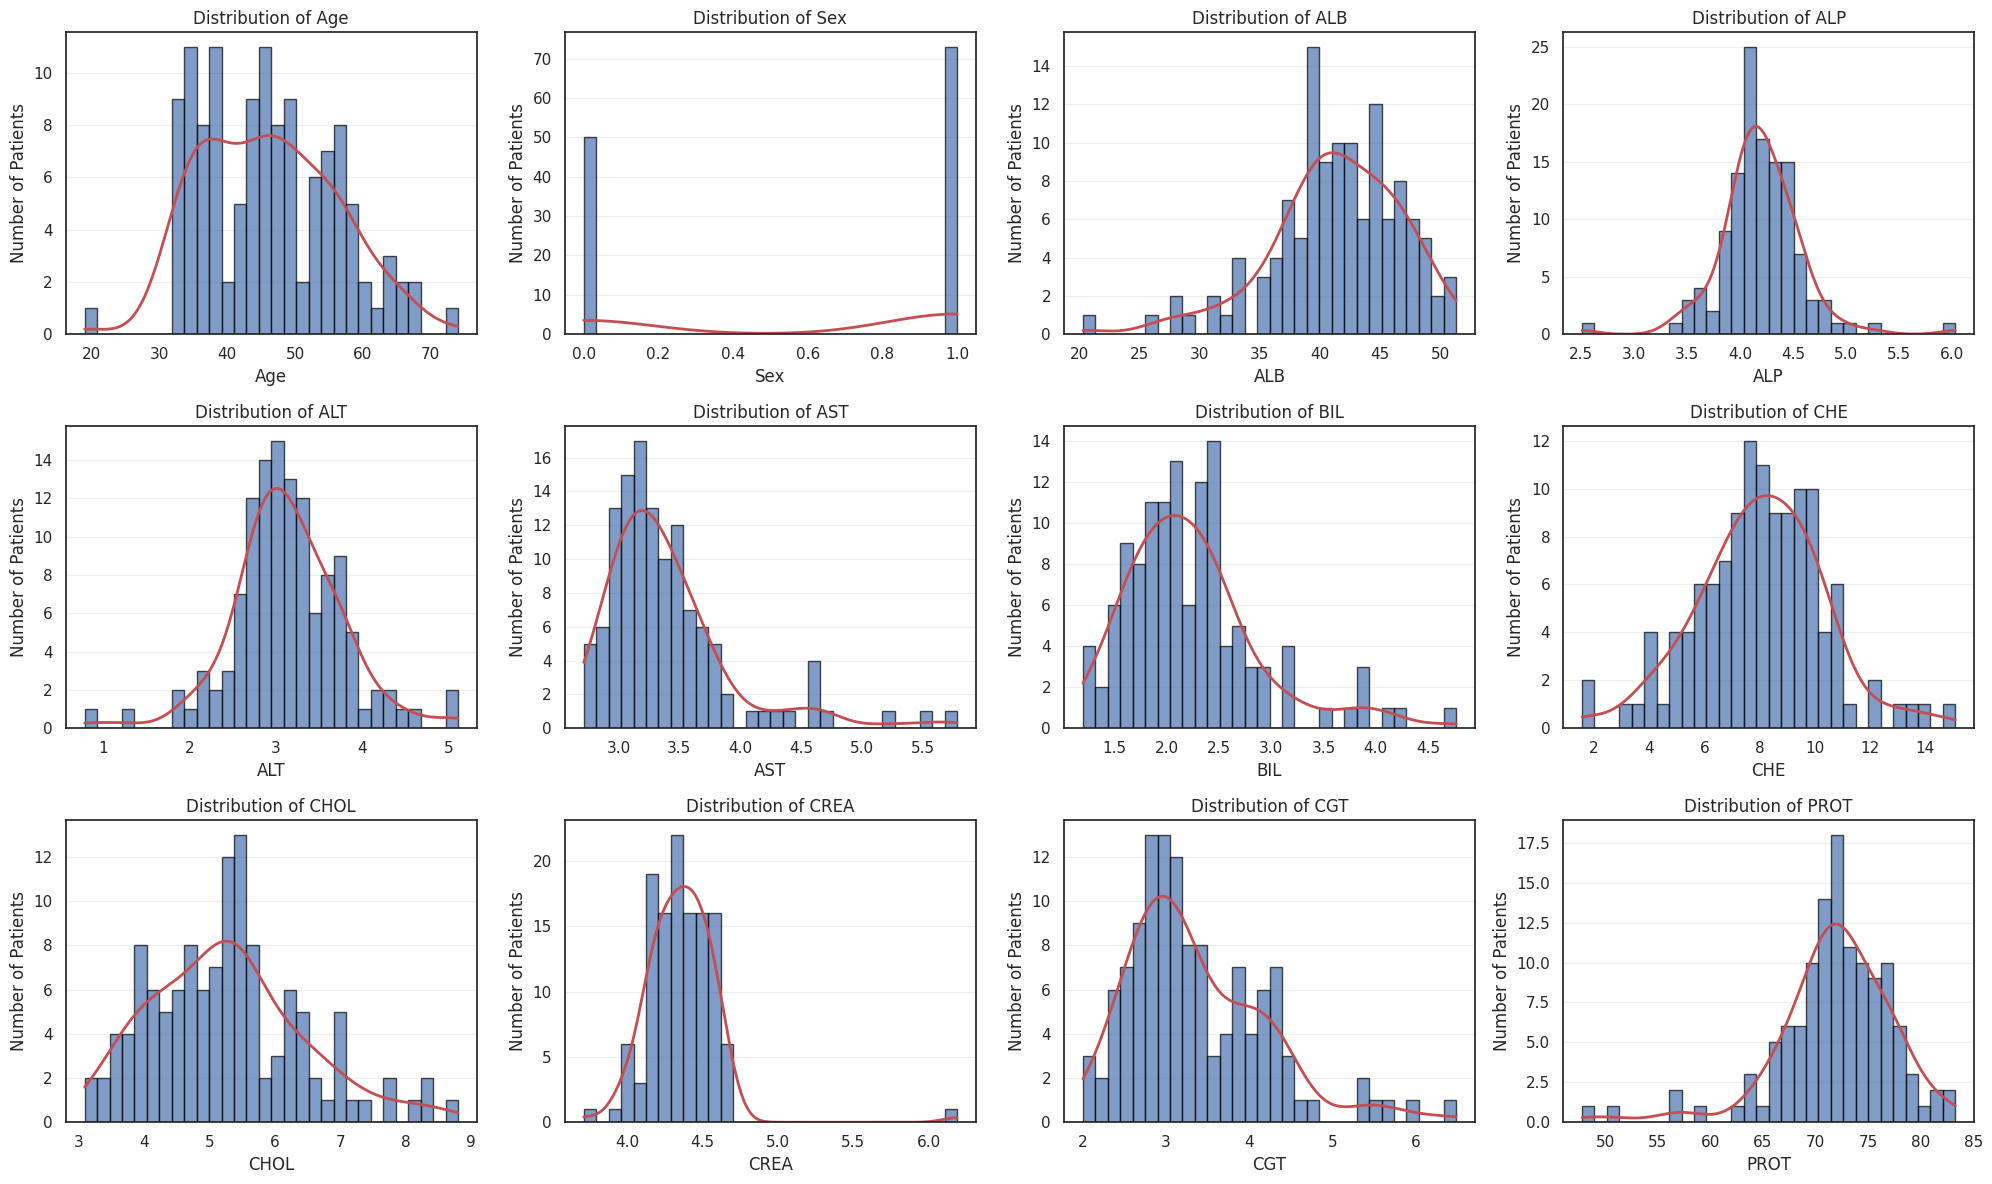

In [179]:
distplots(X_test_log)

In [180]:
#normalize not normal variables (ALL EXCEPT FOR SEX SND CHE) and standardize normal variables (CHE) in split sets
X_train_normalized = X_train_log.copy()
X_test_normalized = X_test_log.copy()

from sklearn.preprocessing import RobustScaler

cols_to_normalize = ['Age', 'ALB', 'AST',
                 'BIL', 'CHOL', 'CREA', 'CGT', 'PROT']

scaler_normalize = RobustScaler()

# Fit on training data and transform both train and test
X_train_normalized[cols_to_normalize] = scaler_normalize.fit_transform(X_train_normalized[cols_to_normalize])
X_test_normalized[cols_to_normalize] = scaler_normalize.transform(X_test_normalized[cols_to_normalize])

print("Train mean:\n", X_train_normalized[cols_to_normalize].mean())
print("Train std:\n", X_train_normalized[cols_to_normalize].std())

print("\nTest mean:\n", X_test_normalized[cols_to_normalize].mean())
print("Test std:\n", X_test_normalized[cols_to_normalize].std())



hcv_X_train = X_train_normalized.copy()
hcv_X_test = X_test_normalized.copy()

#scaling (standardization of variables that are approx. normally distributed bc of large differences in ranges)
from sklearn.preprocessing import StandardScaler

cols_to_standardize = ['ALP', 'ALT', 'CHE']

scaler_standardize = StandardScaler()

# Fit on training data and transform both train and test
hcv_X_train[cols_to_standardize] = scaler_standardize.fit_transform(hcv_X_train[cols_to_standardize])
hcv_X_test[cols_to_standardize] = scaler_standardize.transform(hcv_X_test[cols_to_standardize])



Train mean:
 Age    -0.016802
ALB    -0.045153
AST     0.274080
BIL     0.142514
CHOL    0.065709
CREA    0.018778
CGT     0.163826
PROT   -0.032887
dtype: float64
Train std:
 Age     0.671690
ALB     0.901281
AST     1.221318
BIL     0.899954
CHOL    0.776771
CREA    1.096965
CGT     0.852855
PROT    0.880368
dtype: float64

Test mean:
 Age    -0.130081
ALB    -0.111069
AST     0.266778
BIL     0.169245
CHOL   -0.028597
CREA    0.024389
CGT     0.204270
PROT   -0.077836
dtype: float64
Test std:
 Age     0.659848
ALB     0.837427
AST     1.346999
BIL     0.928173
CHOL    0.819192
CREA    0.964230
CGT     0.984750
PROT    0.905843
dtype: float64


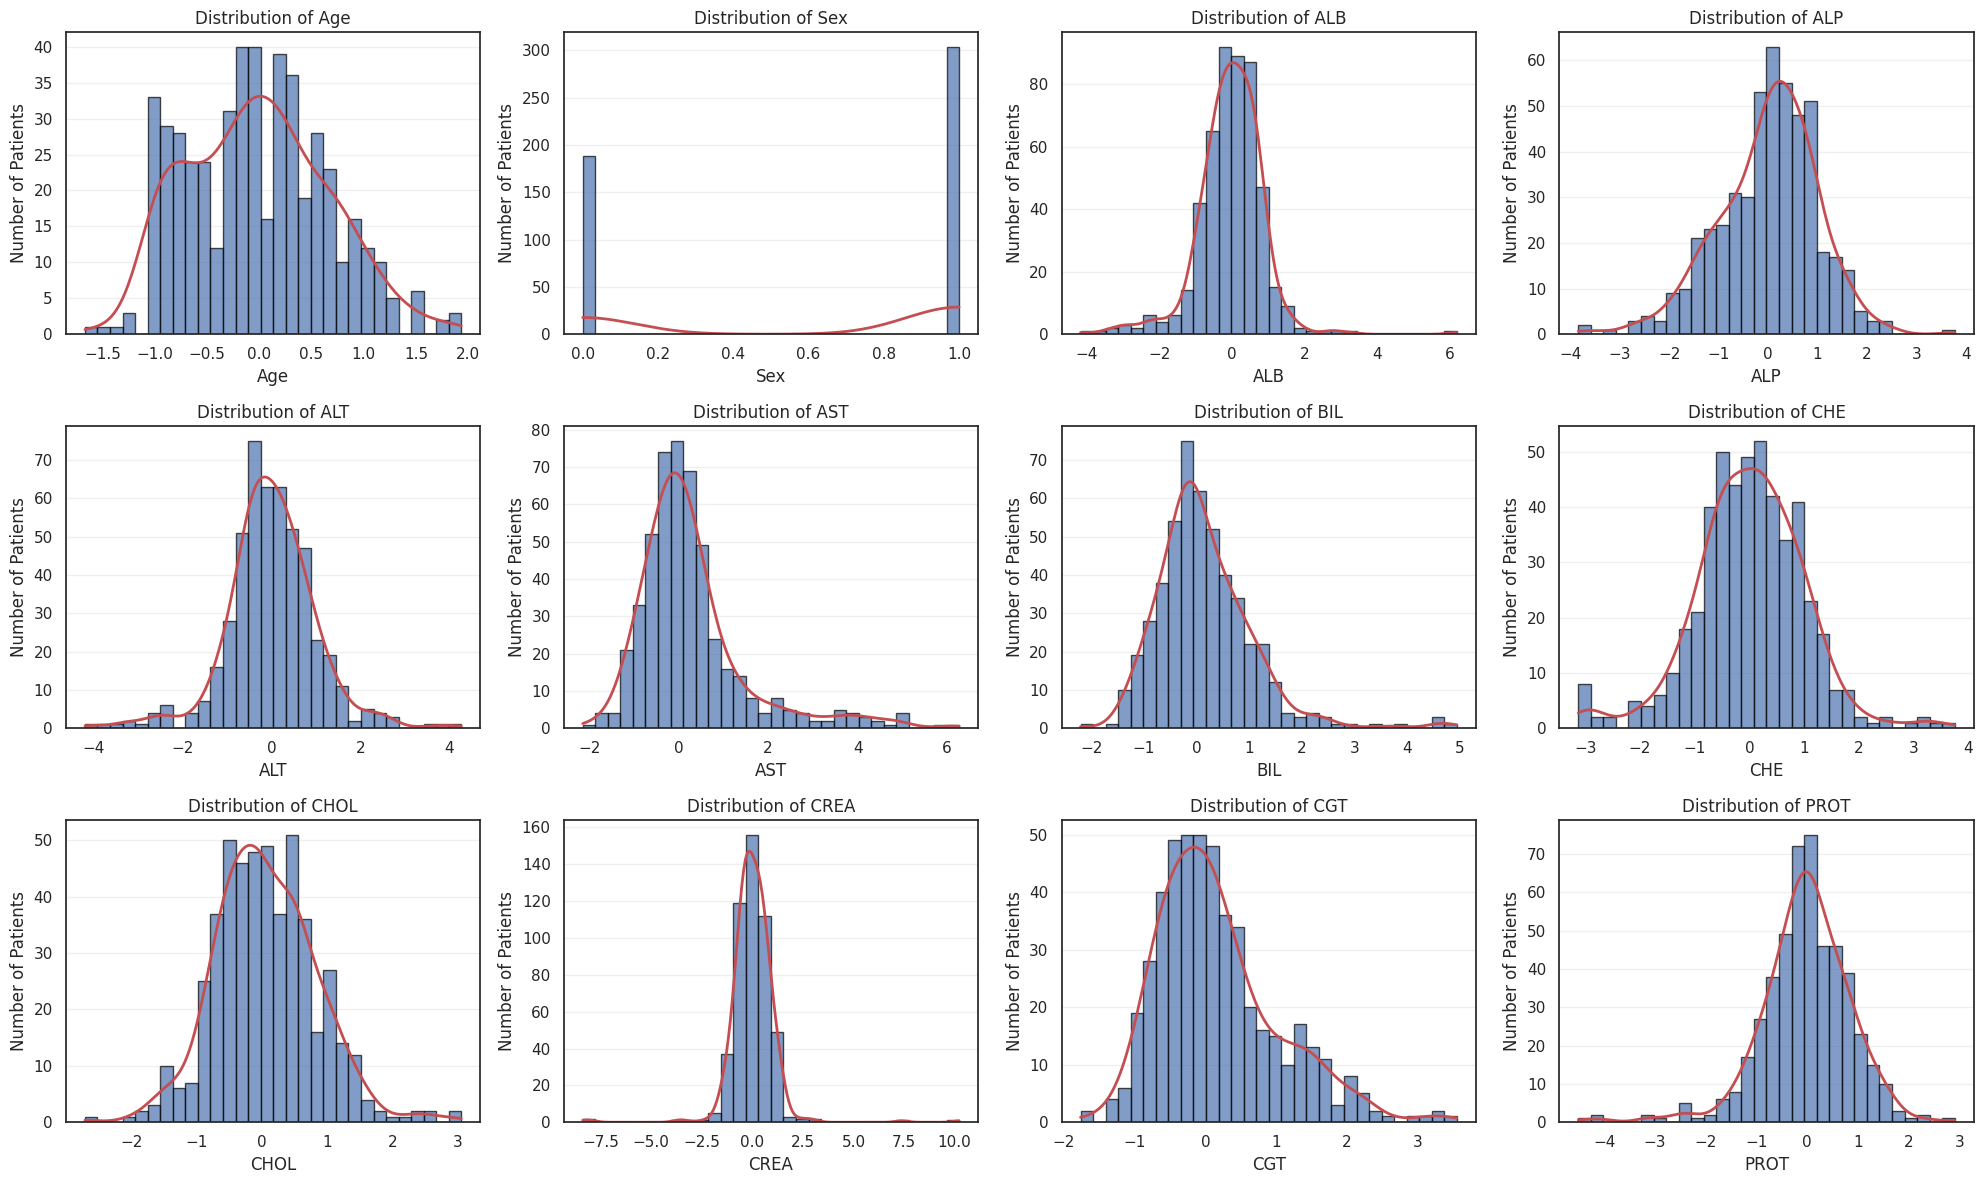

In [181]:
distplots(hcv_X_train)

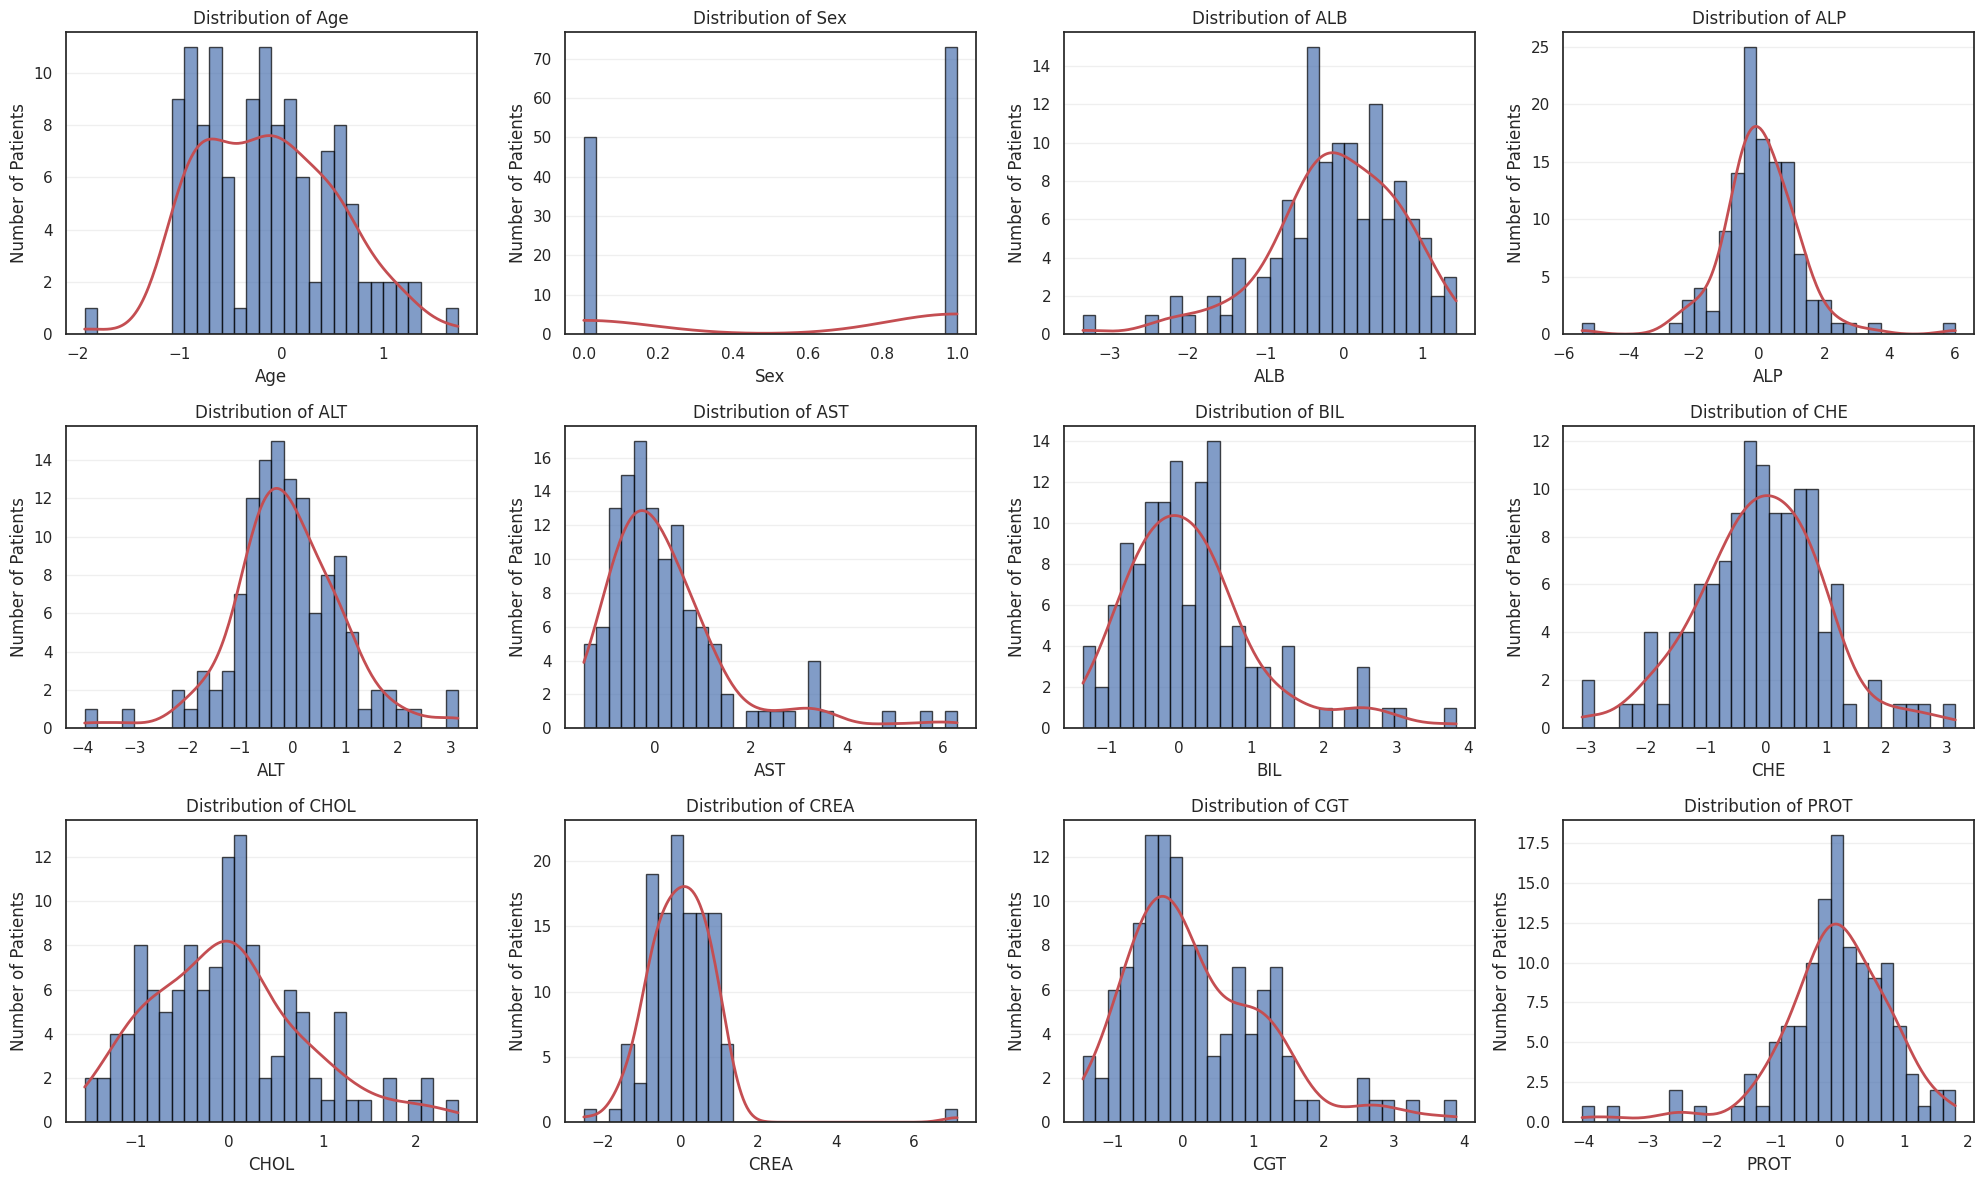

In [182]:
distplots(hcv_X_test)

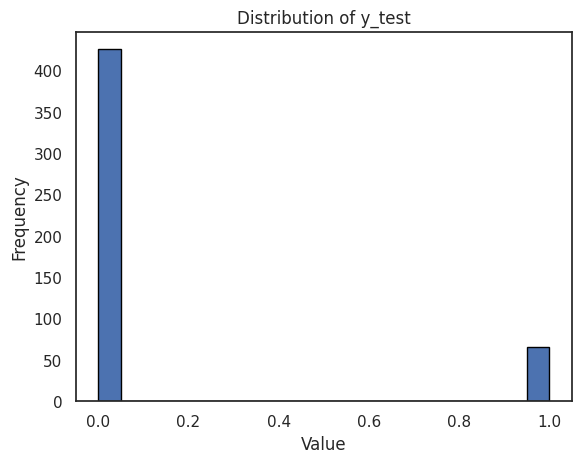

In [183]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=20, edgecolor='black')
plt.title("Distribution of y_test")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

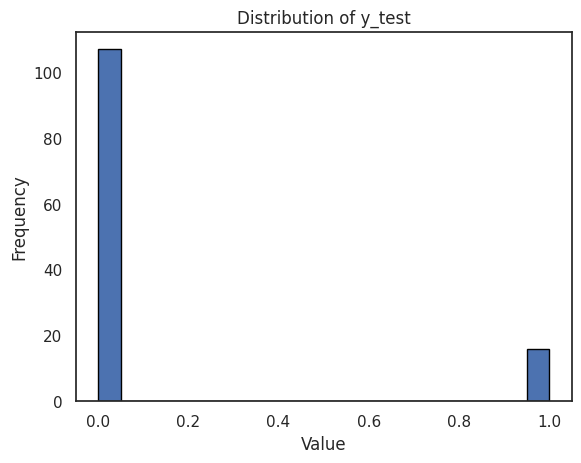

In [184]:
plt.hist(y_test, bins=20, edgecolor='black')
plt.title("Distribution of y_test")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

--> we made all numerical variables be approx. normally distributed and on the same scale

--> our target is imbalanced

## Skewness

In [185]:
"""skewness_check(hcv_imputed)"""

'skewness_check(hcv_imputed)'

In [186]:
"""skewness_check(hcv_normalized)"""

'skewness_check(hcv_normalized)'

In [187]:
skewness_check(X_train_imputed)

Age is symmetric (skew: 0.264)
Sex is symmetric (skew: -0.485)
ALB is symmetric (skew: -0.050)
ALP is moderately right skewed (skew: 0.989)
ALT is strongly right skewed (skew: 5.862)
AST is strongly right skewed (skew: 4.723)
BIL is strongly right skewed (skew: 8.471)
CHE is symmetric (skew: -0.135)
CHOL is symmetric (skew: 0.327)
CREA is strongly right skewed (skew: 15.564)
CGT is strongly right skewed (skew: 4.998)
PROT is moderately left skewed (skew: -0.873)



In [188]:
skewness_check(hcv_X_train)

Age is symmetric (skew: 0.264)
Sex is symmetric (skew: -0.485)
ALB is symmetric (skew: -0.050)
ALP is symmetric (skew: -0.429)
ALT is symmetric (skew: -0.093)
AST is strongly right skewed (skew: 1.905)
BIL is strongly right skewed (skew: 1.519)
CHE is symmetric (skew: -0.135)
CHOL is symmetric (skew: 0.327)
CREA is moderately right skewed (skew: 0.504)
CGT is moderately right skewed (skew: 0.980)
PROT is moderately left skewed (skew: -0.873)



In [189]:
"""distplots(hcv_imputed)"""

'distplots(hcv_imputed)'

In [190]:
"""distplots(hcv_normalized)"""

'distplots(hcv_normalized)'

In [191]:
#make final datasets for target
hcv_y_train = y_train.copy()
hcv_y_test = y_test.copy()

# Datasets after pre-processing

In [192]:
#FINAL DATASETS AFTER PRE-PROCESSING
print(hcv_X_train.shape, hcv_X_test.shape, hcv_y_train.shape, hcv_y_test.shape)

(492, 12) (123, 12) (492,) (123,)


# Logistic Regression - All features

## Logistic Regression Model

In [193]:
"""
hcv_lr = hcv_normalized.copy()
print("Using dataframe: hcv_lr > Copy of hcv_normalized\n")

# 1. Sanity: expected columns
if "Category" not in hcv_lr.columns:
    raise ValueError("Column 'Category' not found. Make sure earlier steps kept 'Category' in the dataframe.")

# Exclude ID column
id_col = [c for c in ["ID"] if c in hcv_lr.columns]

# 2. Create binary outcome: Disease (1) vs Blood Donor (0)
def is_blood_donor(v):
    s = str(v).strip().lower()
    return (s == "0=blood donor") or (s == "0") or ("blood donor" in s and "suspect" not in s)

y = (~hcv_lr["Category"].apply(is_blood_donor)).astype(int)  # 1 = any disease class, 0 = blood donor

# 3. Define X: all columns except target + ID
X = hcv_lr.drop(columns=["Category"] + id_col, errors="ignore")

# If any remaining columns are non-numeric, one-hot encoding (drop first to avoid dummy trap)
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
if cat_cols:
    enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
    X_cat = pd.DataFrame(enc.fit_transform(X[cat_cols]),
                         columns=enc.get_feature_names_out(cat_cols),
                         index=X.index)
    X_num = X.drop(columns=cat_cols)
    X = pd.concat([X_num, X_cat], axis=1)

# Force numeric dtype and drop any columns that are constant after preprocessing
X = X.apply(pd.to_numeric, errors="coerce")
constant_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if constant_cols:
    X = X.drop(columns=constant_cols)

# Align and drop rows with any remaining NaNs
model_df = pd.concat([y.rename("y"), X], axis=1).dropna(axis=0)
y_fit = model_df["y"].astype(int)
X_fit = sm.add_constant(model_df.drop(columns=["y"]), has_constant="add")

# 4. Fit statsmodels Logit (binary logistic regression)
logit_model = sm.Logit(y_fit, X_fit)
result = logit_model.fit(disp=False)
"""

'\nhcv_lr = hcv_normalized.copy()\nprint("Using dataframe: hcv_lr > Copy of hcv_normalized\n")\n\n# 1. Sanity: expected columns\nif "Category" not in hcv_lr.columns:\n    raise ValueError("Column \'Category\' not found. Make sure earlier steps kept \'Category\' in the dataframe.")\n\n# Exclude ID column\nid_col = [c for c in ["ID"] if c in hcv_lr.columns]\n\n# 2. Create binary outcome: Disease (1) vs Blood Donor (0)\ndef is_blood_donor(v):\n    s = str(v).strip().lower()\n    return (s == "0=blood donor") or (s == "0") or ("blood donor" in s and "suspect" not in s)\n\ny = (~hcv_lr["Category"].apply(is_blood_donor)).astype(int)  # 1 = any disease class, 0 = blood donor\n\n# 3. Define X: all columns except target + ID\nX = hcv_lr.drop(columns=["Category"] + id_col, errors="ignore")\n\n# If any remaining columns are non-numeric, one-hot encoding (drop first to avoid dummy trap)\ncat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]\nif cat_c

## Summarize coefficients → Odds Ratios with 95% CI

In [194]:
"""
coef = result.params
se = result.bse
z = 1.96

summary_df = pd.DataFrame({
    "feature": coef.index,
    "coef": coef.values,
    "OR": np.exp(coef.values),
    "CI_lower": np.exp(coef.values - z*se.values),
    "CI_upper": np.exp(coef.values + z*se.values),
    "p_value": result.pvalues.values
}).query("feature != 'const'").sort_values("OR")

display(summary_df.style.format({
    "coef": "{:.3f}",
    "OR": "{:.3f}",
    "CI_lower": "{:.3f}",
    "CI_upper": "{:.3f}",
    "p_value": "{:.3f}"
}))
"""

'\ncoef = result.params\nse = result.bse\nz = 1.96\n\nsummary_df = pd.DataFrame({\n    "feature": coef.index,\n    "coef": coef.values,\n    "OR": np.exp(coef.values),\n    "CI_lower": np.exp(coef.values - z*se.values),\n    "CI_upper": np.exp(coef.values + z*se.values),\n    "p_value": result.pvalues.values\n}).query("feature != \'const\'").sort_values("OR")\n\ndisplay(summary_df.style.format({\n    "coef": "{:.3f}",\n    "OR": "{:.3f}",\n    "CI_lower": "{:.3f}",\n    "CI_upper": "{:.3f}",\n    "p_value": "{:.3f}"\n}))\n'

## Forest Plot

In [195]:
"""
plot_df = summary_df.copy()
plot_df = plot_df.reindex(plot_df['OR'].sub(1).abs().sort_values(ascending=False).index)

sig = plot_df["p_value"] < 0.05
ypos = np.arange(len(plot_df))

plt.figure(figsize=(10, 0.7 * len(plot_df)))
sns.set_style("whitegrid")

# Plot non-significant
plt.errorbar(
    x=plot_df.loc[~sig, "OR"], y=ypos[~sig],
    xerr=[plot_df.loc[~sig, "OR"] - plot_df.loc[~sig, "CI_lower"],
          plot_df.loc[~sig, "CI_upper"] - plot_df.loc[~sig, "OR"]],
    fmt='o', capsize=4, color='gray', markersize=6, label='p ≥ 0.05', elinewidth=1.5
)

# Plot significant
plt.errorbar(
    x=plot_df.loc[sig, "OR"], y=ypos[sig],
    xerr=[plot_df.loc[sig, "OR"] - plot_df.loc[sig, "CI_lower"],
          plot_df.loc[sig, "CI_upper"] - plot_df.loc[sig, "OR"]],
    fmt='o', capsize=4, color='tab:blue', markersize=6, label='p < 0.05', elinewidth=1.5
)

# Reference line
plt.axvline(1, color="black", linestyle="--", lw=1)

# Gridlines and axes
plt.grid(True, which="both", axis="x", linestyle="--", alpha=0.4)
plt.yticks(ypos, plot_df["feature"], fontsize=12)
plt.xscale("log")
plt.xticks([0.1, 0.5, 1, 2, 5, 10], ['0.1', '0.5', '1', '2', '5', '10'])
plt.xlabel("Odds Ratio (log scale), 95% CI", fontsize=13)
plt.title("Logistic Regression Forest Plot (sorted by |OR−1|)", fontsize=14)

# Annotate OR values
for i, row in enumerate(plot_df.itertuples()):
    offset = 0.05 if row.OR < 1 else -0.05
    ha = 'left' if row.OR < 1 else 'right'
    plt.text(row.OR * (1 + offset), i,
             f"{row.OR:.2f}",
             va='center', ha=ha,
             fontsize=11, fontweight='bold',
             color='black')

plt.legend(frameon=True, fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()
"""

'\nplot_df = summary_df.copy()\nplot_df = plot_df.reindex(plot_df[\'OR\'].sub(1).abs().sort_values(ascending=False).index)\n\nsig = plot_df["p_value"] < 0.05\nypos = np.arange(len(plot_df))\n\nplt.figure(figsize=(10, 0.7 * len(plot_df)))\nsns.set_style("whitegrid")\n\n# Plot non-significant\nplt.errorbar(\n    x=plot_df.loc[~sig, "OR"], y=ypos[~sig],\n    xerr=[plot_df.loc[~sig, "OR"] - plot_df.loc[~sig, "CI_lower"],\n          plot_df.loc[~sig, "CI_upper"] - plot_df.loc[~sig, "OR"]],\n    fmt=\'o\', capsize=4, color=\'gray\', markersize=6, label=\'p ≥ 0.05\', elinewidth=1.5\n)\n\n# Plot significant\nplt.errorbar(\n    x=plot_df.loc[sig, "OR"], y=ypos[sig],\n    xerr=[plot_df.loc[sig, "OR"] - plot_df.loc[sig, "CI_lower"],\n          plot_df.loc[sig, "CI_upper"] - plot_df.loc[sig, "OR"]],\n    fmt=\'o\', capsize=4, color=\'tab:blue\', markersize=6, label=\'p < 0.05\', elinewidth=1.5\n)\n\n# Reference line\nplt.axvline(1, color="black", linestyle="--", lw=1)\n\n# Gridlines and axes\nplt.

## Model quality readouts

In [196]:
"""
pred_prob = result.predict(X_fit)
auc = roc_auc_score(y_fit, pred_prob)

# McFadden's pseudo-R2
llf = result.llf            # log-likelihood of fitted model
llnull = result.llnull      # log-likelihood of null (intercept-only) model
mcfadden_r2 = 1 - (llf / llnull)

print(f"AUC: {auc:.3f}")
print(f"McFadden's pseudo-R²: {mcfadden_r2:.3f}")
"""

'\npred_prob = result.predict(X_fit)\nauc = roc_auc_score(y_fit, pred_prob)\n\n# McFadden\'s pseudo-R2\nllf = result.llf            # log-likelihood of fitted model\nllnull = result.llnull      # log-likelihood of null (intercept-only) model\nmcfadden_r2 = 1 - (llf / llnull)\n\nprint(f"AUC: {auc:.3f}")\nprint(f"McFadden\'s pseudo-R²: {mcfadden_r2:.3f}")\n'

In [197]:
"""
x_train_Sm= sm.add_constant(X)
model_sm = sm.Logit(y, x_train_Sm).fit()
print(model_sm.summary())
"""

'\nx_train_Sm= sm.add_constant(X)\nmodel_sm = sm.Logit(y, x_train_Sm).fit()\nprint(model_sm.summary())\n'

## Confusion Matrix

In [198]:
"""
print("Prevalence (disease=1):", y_fit.mean().round(3))

y_hat = (pred_prob >= 0.4).astype(int)
cm = confusion_matrix(y_fit, y_hat, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Donor (0)", "Disease (1)"])
disp.plot(values_format='d')
plt.title("Confusion Matrix @ 0.4 threshold")
plt.show()

print(classification_report(y_fit, y_hat, target_names=["Donor (0)","Disease (1)"]))
"""

'\nprint("Prevalence (disease=1):", y_fit.mean().round(3))\n\ny_hat = (pred_prob >= 0.4).astype(int)\ncm = confusion_matrix(y_fit, y_hat, labels=[0,1])\ndisp = ConfusionMatrixDisplay(cm, display_labels=["Donor (0)", "Disease (1)"])\ndisp.plot(values_format=\'d\')\nplt.title("Confusion Matrix @ 0.4 threshold")\nplt.show()\n\nprint(classification_report(y_fit, y_hat, target_names=["Donor (0)","Disease (1)"]))\n'

# Logistic Regression - Selected features (& All features)

## Feature selection

In [199]:
"""hcv_logr = hcv_normalized.copy()"""
hcv_X_train_logr = hcv_X_train.copy()
hcv_X_test_logr = hcv_X_test.copy()
hcv_y_train_logr = hcv_y_train.copy()
hcv_y_test_logr = hcv_y_test.copy()

<Axes: >

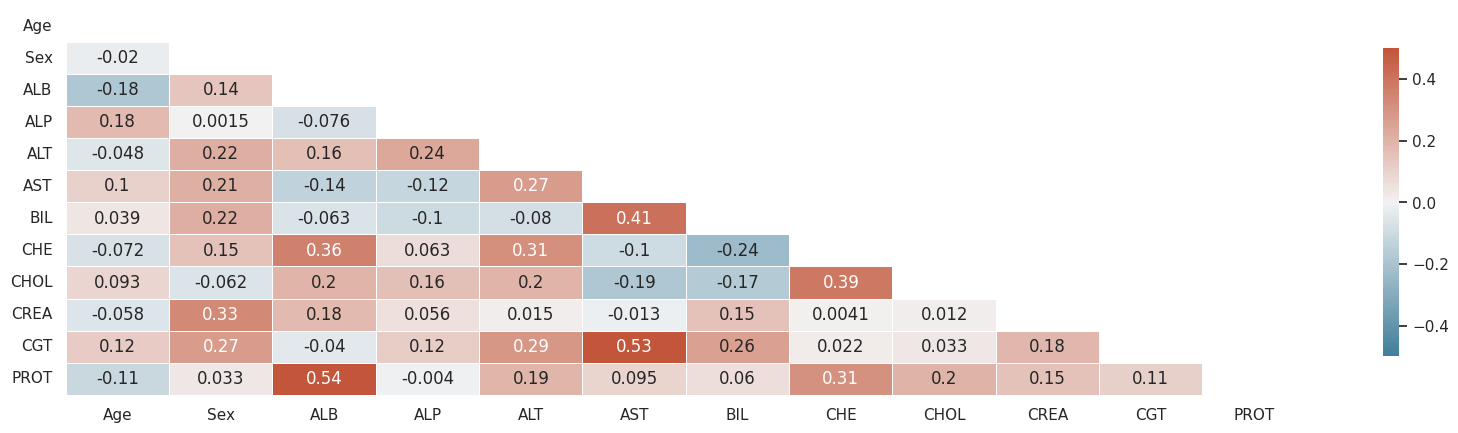

In [200]:
#check correlations
sns.set_theme(style="white")

# Compute the correlation matrix
corr = hcv_X_train_logr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,annot = True,
             linewidths=.5, cbar_kws={"shrink": .8})

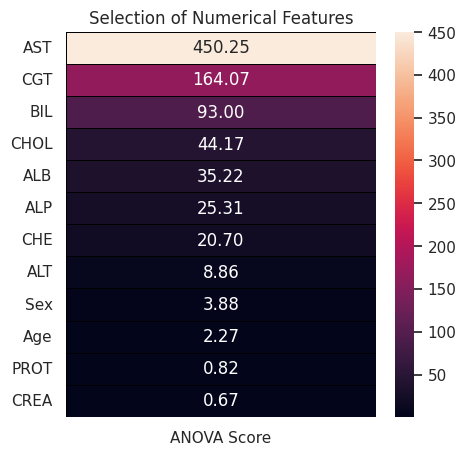

In [201]:
#select numerical features (age and lab results) using ANOVA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

features = hcv_X_train_logr.copy()
target = hcv_y_train_logr.copy()

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f')
plt.title('Selection of Numerical Features');

--> one dataset with the most correlated features (excl. sex, prot, crea, age, alt, alp, che, alb) - hcv_logr_selected_strict , one dataset with mostly correlated features (excl. sex, prot, crea, age) hcv_logr_selected and one full dataset - hcv_logr_full

In [202]:
hcv_X_train_logr_full = hcv_X_train_logr.copy()
hcv_X_test_logr_full = hcv_X_test_logr.copy()

hcv_X_train_logr_selected = hcv_X_train_logr.drop(columns=['Sex', 'PROT', 'CREA', 'Age'])
hcv_X_test_logr_selected = hcv_X_test_logr.drop(columns=['Sex', 'PROT', 'CREA', 'Age'])

hcv_X_train_logr_selected_strict = hcv_X_train_logr.drop(columns=['Sex', 'PROT', 'CREA', 'Age', 'ALT', 'ALP', 'CHE', 'ALB'])
hcv_X_test_logr_selected_strict = hcv_X_test_logr.drop(columns=['Sex', 'PROT', 'CREA', 'Age', 'ALT', 'ALP', 'CHE', 'ALB'])

## Training/test set

In [203]:
'''
##Bad features dataset

# Splitting into features (X) and target (y)
X = hcv_logr[['Sex', 'Age']].values
y = hcv_logr['Category'].values

# Create a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3003)

# Fit logistic regression model using scikit-learn
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced')
model_LR.fit(X_train, y_train)

# Predictions on the full set
y_pred = model_LR.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
# Print the results
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_rep)

#Also display confusion matrix (normalized)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test,
                 y_pred=y_pred, normalize='true')

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_LR.classes_)
disp.plot();
'''

'\n##Bad features dataset\n\n# Splitting into features (X) and target (y)\nX = hcv_logr[[\'Sex\', \'Age\']].values\ny = hcv_logr[\'Category\'].values\n\n# Create a training and test set\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3003)\n\n# Fit logistic regression model using scikit-learn\nfrom sklearn.linear_model import LogisticRegression\nmodel_LR = LogisticRegression(multi_class=\'auto\', max_iter=1000, class_weight=\'balanced\')\nmodel_LR.fit(X_train, y_train)\n\n# Predictions on the full set\ny_pred = model_LR.predict(X_test)\n\n# Evaluate the performance\naccuracy = accuracy_score(y_test, y_pred)\nclassification_rep = classification_report(y_test, y_pred)\n# Print the results\nprint(f"Accuracy: {accuracy:.3f}")\nprint("Classification Report:\n", classification_rep)\n\n#Also display confusion matrix (normalized)\nfrom sklearn.metrics import confusion_matrix\ncm = confusion_matrix(y_true=y_test,\n                 y_pred=y_pred, normalize=

Accuracy: 0.911
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       107
           1       0.61      0.88      0.72        16

    accuracy                           0.91       123
   macro avg       0.79      0.90      0.83       123
weighted avg       0.93      0.91      0.92       123



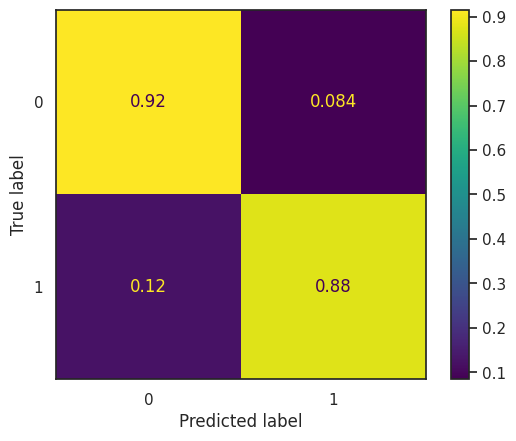

In [204]:
##Full dataset

# Fit logistic regression model using scikit-learn
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced')
model_LR.fit(hcv_X_train_logr_full, hcv_y_train_logr)

# Predictions on the full set
y_pred = model_LR.predict(hcv_X_test_logr_full)

# Evaluate the performance
accuracy = accuracy_score(hcv_y_test_logr, y_pred)
classification_rep = classification_report(hcv_y_test_logr, y_pred)
# Print the results
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_rep)

#Also display confusion matrix (normalized)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=hcv_y_test_logr,
                 y_pred=y_pred, normalize='true')

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_LR.classes_)
disp.plot();

Accuracy: 0.943
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97       107
           1       0.71      0.94      0.81        16

    accuracy                           0.94       123
   macro avg       0.85      0.94      0.89       123
weighted avg       0.95      0.94      0.95       123



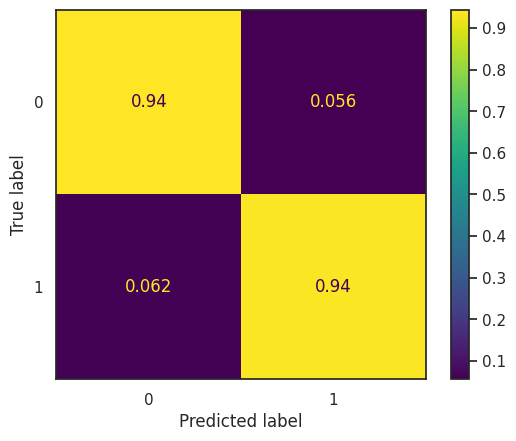

In [205]:
##Selected features dataset

# Fit logistic regression model using scikit-learn
from sklearn.linear_model import LogisticRegression
model_LR_best = LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced')
model_LR_best.fit(hcv_X_train_logr_selected, hcv_y_train_logr)

# Predictions on the full set
y_pred = model_LR_best.predict(hcv_X_test_logr_selected)

# Evaluate the performance
accuracy = accuracy_score(hcv_y_test_logr, y_pred)
classification_rep = classification_report(hcv_y_test_logr, y_pred)
# Print the results
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_rep)

#Also display confusion matrix (normalized)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=hcv_y_test_logr,
                 y_pred=y_pred, normalize='true')

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_LR.classes_)
disp.plot();

Accuracy: 0.911
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       107
           1       0.62      0.81      0.70        16

    accuracy                           0.91       123
   macro avg       0.79      0.87      0.83       123
weighted avg       0.92      0.91      0.92       123



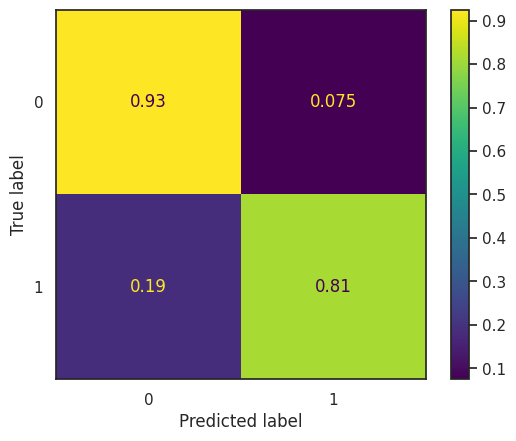

In [206]:
##Strictly selected features dataset

# Fit logistic regression model using scikit-learn
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced')
model_LR.fit(hcv_X_train_logr_selected_strict, hcv_y_train_logr)

# Predictions on the full set
y_pred = model_LR.predict(hcv_X_test_logr_selected_strict)

# Evaluate the performance
accuracy = accuracy_score(hcv_y_test_logr, y_pred)
classification_rep = classification_report(hcv_y_test_logr, y_pred)
# Print the results
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_rep)

#Also display confusion matrix (normalized)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=hcv_y_test_logr,
                 y_pred=y_pred, normalize='true')

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_LR.classes_)
disp.plot();

## K-fold cross-validation

In [207]:
##Full dataset


# K-fold cross-validation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

"""from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler() #??
X = min_max_scaler.fit_transform(X)"""

# Evaluate the model using cross-validation
scores = cross_val_score(model_LR, hcv_X_train_logr_full, hcv_y_train_logr, scoring='accuracy', cv=cv, n_jobs=-1)
# options for scoring: scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Print the average accuracy and the standard deviation
print('Accuracy: %.3f \u00B1 %.3f' % (np.mean(scores), np.std(scores)))

Accuracy: 0.941 ± 0.019


In [208]:
##Selected features dataset

# K-fold cross-validation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(model_LR, hcv_X_train_logr_selected, hcv_y_train_logr, scoring='accuracy', cv=cv, n_jobs=-1)
# options for scoring: scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Print the average accuracy and the standard deviation
print('Accuracy: %.3f \u00B1 %.3f' % (np.mean(scores), np.std(scores)))

Accuracy: 0.945 ± 0.018


In [209]:
##Strictly selected features dataset

# K-fold cross-validation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(model_LR, hcv_X_train_logr_selected_strict, hcv_y_train_logr, scoring='accuracy', cv=cv, n_jobs=-1)
# options for scoring: scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Print the average accuracy and the standard deviation
print('Accuracy: %.3f \u00B1 %.3f' % (np.mean(scores), np.std(scores)))

Accuracy: 0.923 ± 0.023


## Probabilistic model selection (AIC/BIC)

In [210]:
##Full dataset


# Do not split the data into training and testing sets: AIC and BIC account for under/overfitting by the penalty term
#I have to join train and test back:
import pandas as pd
# Combine feature sets
X_logr = pd.concat([hcv_X_train_logr_full, hcv_X_test_logr_full], axis=0).reset_index(drop=True)
# Combine target variables
y_logr = pd.concat([hcv_y_train_logr, hcv_y_test_logr], axis=0).reset_index(drop=True)

model_LR.fit(X_logr, y_logr)

# Predictions on the full set
y_pred = model_LR.predict(X_logr)

# Calculate log likelihood (negative log-likelihood) for the full set
from sklearn.metrics import log_loss

n_samples = len(y_logr)
log_likelihood = -log_loss(y_logr, model_LR.predict_proba(X_logr)) * n_samples
print(f"Log-likelihood: {log_likelihood}")

# Calculate AIC and BIC
num_classes = len(np.unique(y_logr))  # number of classes
num_params = (X_logr.shape[1] + 1) * (num_classes - 1) # Number of parameters (features + intercept) * number of classes - 1
aic = 2 * num_params - 2 * log_likelihood
bic = np.log(n_samples) * num_params - 2 * log_likelihood

# Display AIC and BIC
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Log-likelihood: -93.27254266041149
AIC: 212.54508532082298
BIC: 270.0261748023077


In [211]:
##Selected features dataset

# Do not split the data into training and testing sets: AIC and BIC account for under/overfitting by the penalty term
#I have to join train and test back:
import pandas as pd
# Combine feature sets
X_logr_selected = pd.concat([hcv_X_train_logr_selected, hcv_X_test_logr_selected], axis=0).reset_index(drop=True)
# Combine target variables
y_logr = pd.concat([hcv_y_train_logr, hcv_y_test_logr], axis=0).reset_index(drop=True)

model_LR.fit(X_logr_selected, y_logr)

# Predictions on the full set
y_pred = model_LR.predict(X_logr_selected)

# Calculate log likelihood (negative log-likelihood) for the full set
from sklearn.metrics import log_loss

n_samples = len(y_logr)
log_likelihood = -log_loss(y_logr, model_LR.predict_proba(X_logr_selected)) * n_samples
print(f"Log-likelihood: {log_likelihood}")

# Calculate AIC and BIC
num_classes = len(np.unique(y_logr))  # number of classes
num_params = (X_logr_selected.shape[1] + 1) * (num_classes - 1) # Number of parameters (features + intercept) * number of classes - 1
aic = 2 * num_params - 2 * log_likelihood
bic = np.log(n_samples) * num_params - 2 * log_likelihood

# Display AIC and BIC
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Log-likelihood: -94.3635939314978
AIC: 206.7271878629956
BIC: 246.52178827325426


In [212]:
##Strictly selected features dataset

# Do not split the data into training and testing sets: AIC and BIC account for under/overfitting by the penalty term
#I have to join train and test back:
import pandas as pd
# Combine feature sets
X_logr_selected_strict = pd.concat([hcv_X_train_logr_selected_strict, hcv_X_test_logr_selected_strict], axis=0).reset_index(drop=True)
# Combine target variables
y_logr = pd.concat([hcv_y_train_logr, hcv_y_test_logr], axis=0).reset_index(drop=True)

model_LR.fit(X_logr_selected_strict, y_logr)

# Predictions on the full set
y_pred = model_LR.predict(X_logr_selected_strict)

# Calculate log likelihood (negative log-likelihood) for the full set
from sklearn.metrics import log_loss

n_samples = len(y_logr)
log_likelihood = -log_loss(y_logr, model_LR.predict_proba(X_logr_selected_strict)) * n_samples
print(f"Log-likelihood: {log_likelihood}")

# Calculate AIC and BIC
num_classes = len(np.unique(y_logr))  # number of classes
num_params = (X_logr_selected_strict.shape[1] + 1) * (num_classes - 1) # Number of parameters (features + intercept) * number of classes - 1
aic = 2 * num_params - 2 * log_likelihood
bic = np.log(n_samples) * num_params - 2 * log_likelihood

# Display AIC and BIC
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Log-likelihood: -141.37267400344552
AIC: 292.74534800689105
BIC: 314.8534593459236


AIC/BIC curve

Best combinations per feature size:
size=1: features=['AST'], AIC=371.80, BIC=380.64, LL=-183.90
size=2: features=['ALT', 'AST'], AIC=290.75, BIC=304.01, LL=-142.37
size=3: features=['ALT', 'AST', 'CGT'], AIC=249.07, BIC=266.75, LL=-120.53
size=4: features=['ALT', 'AST', 'CHOL', 'CGT'], AIC=227.56, BIC=249.67, LL=-108.78
size=5: features=['ALP', 'ALT', 'AST', 'CHOL', 'CGT'], AIC=207.62, BIC=234.15, LL=-97.81
size=6: features=['ALB', 'ALP', 'ALT', 'AST', 'CHOL', 'CGT'], AIC=204.42, BIC=235.37, LL=-95.21
size=7: features=['Age', 'ALB', 'ALP', 'ALT', 'AST', 'CHOL', 'CGT'], AIC=204.30, BIC=239.67, LL=-94.15
size=8: features=['Age', 'ALB', 'ALP', 'ALT', 'AST', 'CHOL', 'CGT', 'PROT'], AIC=205.39, BIC=245.18, LL=-93.69
size=9: features=['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHOL', 'CGT', 'PROT'], AIC=207.07, BIC=251.29, LL=-93.54
size=10: features=['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CGT', 'PROT'], AIC=208.73, BIC=257.37, LL=-93.37
size=11: features=['Age', 'ALB', '

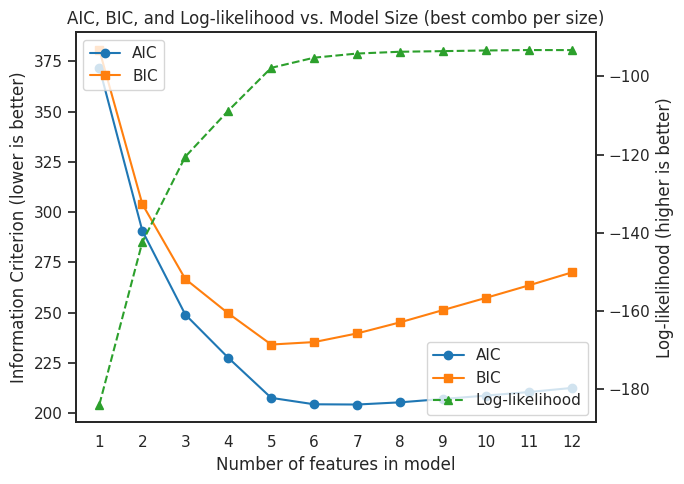

In [213]:
import itertools
import matplotlib.pyplot as plt

feature_names = X_logr.columns
K = len(np.unique(y_logr))  # number of classes

# define a function to compute log-likelihood, AIC and BIC and number of parameters
def fit_and_ic(Xsub, y):
    """
    Fit multinomial logistic regression and return log-likelihood, AIC, BIC.
    Uses parameter count for multinomial: (p + 1) * (K - 1)
    """
    n_samples, p = Xsub.shape
    model = LogisticRegression(
        multi_class="auto", max_iter=1000, class_weight = 'balanced'
    )
    model.fit(Xsub, y)

    proba = model.predict_proba(Xsub)
    # log_loss is average negative log-likelihood; multiply by n to get total,
    # and take negative to get log-likelihood.
    ll = -log_loss(y, proba, labels=model.classes_) * n_samples

    num_params = (p + 1) * (K - 1)  # p slopes + 1 intercept per (K-1)
    aic = 2 * num_params - 2 * ll
    bic = np.log(n_samples) * num_params - 2 * ll
    return ll, aic, bic, num_params

records = []
# Try all combinations of 1..4 features
for r in range(1, X_logr.shape[1] + 1):
    for combo_idx in itertools.combinations(range(X.shape[1]), r):
        combo_names = [feature_names[i] for i in combo_idx]
        X_sub = X_logr.iloc[:, list(combo_idx)]
        ll, aic, bic, k = fit_and_ic(X_sub, y_logr)
        records.append({
            "size": r,
            "features": combo_names,
            "log_likelihood": ll,
            "AIC": aic,
            "BIC": bic,
            "num_params": k
        })

results_df = pd.DataFrame(records).sort_values(["size", "log_likelihood"]).reset_index(drop=True)

# Pick best (highest) likelihood per model size
best_by_size = results_df.loc[results_df.groupby("size")["log_likelihood"].idxmax()].sort_values("size")

print("Best combinations per feature size:")
for _, row in best_by_size.iterrows():
    print(f"size={row['size']}: features={row['features']}, AIC={row['AIC']:.2f}, "
          f"BIC={row['BIC']:.2f}, LL={row['log_likelihood']:.2f}")

# --- Plot ---
sizes = best_by_size["size"].values
aic_vals = best_by_size["AIC"].values
bic_vals = best_by_size["BIC"].values
ll_vals = best_by_size["log_likelihood"].values

fig, ax1 = plt.subplots(figsize=(7,5))

# AIC/BIC (primary y-axis)
ax1.plot(sizes, aic_vals, marker="o", label="AIC", color="tab:blue")
ax1.plot(sizes, bic_vals, marker="s", label="BIC", color="tab:orange")
ax1.set_xlabel("Number of features in model")
ax1.set_ylabel("Information Criterion (lower is better)")
ax1.set_xticks(sizes)
ax1.legend(loc="upper left")

# Log-likelihood (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(sizes, ll_vals, marker="^", linestyle="--", color="tab:green", label="Log-likelihood")
ax2.set_ylabel("Log-likelihood (higher is better)")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="best")

plt.title("AIC, BIC, and Log-likelihood vs. Model Size (best combo per size)")
plt.tight_layout()
plt.show()

In [214]:
print(feature_names)

Index(['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA',
       'CGT', 'PROT'],
      dtype='object')


Accuracy: 0.951
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       107
           1       0.75      0.94      0.83        16

    accuracy                           0.95       123
   macro avg       0.87      0.95      0.90       123
weighted avg       0.96      0.95      0.95       123



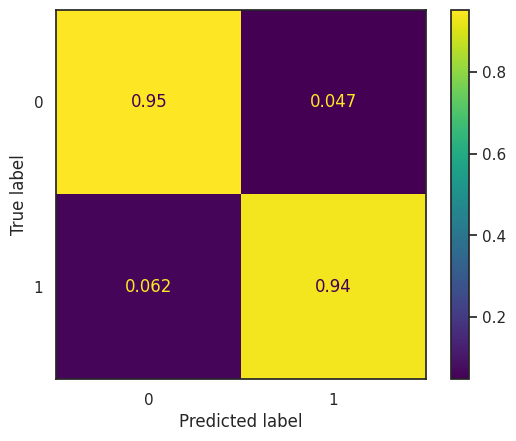

In [215]:
#Now build another LR model but with 6 features as proposed above

## dataset with 6 features: ['ALB', 'ALP', 'ALT', 'AST', 'CHOL', 'CGT']

features_to_keep = ['ALB', 'ALP', 'ALT', 'AST', 'CHOL', 'CGT']
hcv_X_train_logr_6 = hcv_X_train_logr[features_to_keep]
hcv_X_test_logr_6 = hcv_X_test_logr[features_to_keep]

# Fit logistic regression model using scikit-learn
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced')
model_LR.fit(hcv_X_train_logr_6, hcv_y_train_logr)

# Predictions on the full set
y_pred = model_LR.predict(hcv_X_test_logr_6)

# Evaluate the performance
accuracy = accuracy_score(hcv_y_test_logr, y_pred)
classification_rep = classification_report(hcv_y_test_logr, y_pred)
# Print the results
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_rep)

#Also display confusion matrix (normalized)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=hcv_y_test_logr,
                 y_pred=y_pred, normalize='true')

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_LR.classes_)
disp.plot();

In [216]:
## dataset with 6 features: ['ALB', 'ALP', 'ALT', 'AST', 'CHOL', 'CGT']

# K-fold cross-validation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

"""from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler() #??
X = min_max_scaler.fit_transform(X)"""

# Evaluate the model using cross-validation
scores = cross_val_score(model_LR, hcv_X_train_logr_6, hcv_y_train_logr, scoring='accuracy', cv=cv, n_jobs=-1)
# options for scoring: scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Print the average accuracy and the standard deviation
print('Accuracy: %.3f \u00B1 %.3f' % (np.mean(scores), np.std(scores)))

Accuracy: 0.946 ± 0.017


Accuracy: 0.959
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98       107
           1       0.76      1.00      0.86        16

    accuracy                           0.96       123
   macro avg       0.88      0.98      0.92       123
weighted avg       0.97      0.96      0.96       123



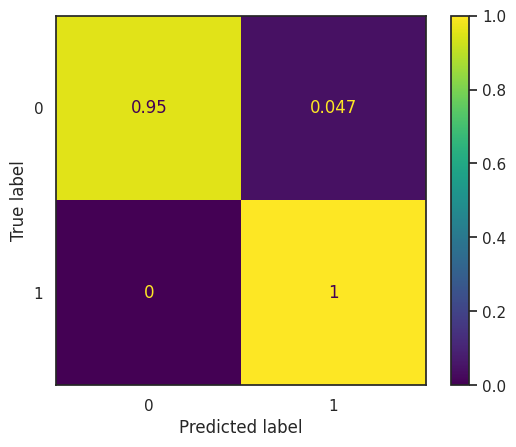

In [217]:
#Now build another LR model but with 5 features as proposed above

## dataset with 5 features: ['ALP', 'ALT', 'AST', 'CHOL', 'CGT']

features_to_keep_5 = ['ALP', 'ALT', 'AST', 'CHOL', 'CGT']
hcv_X_train_logr_5 = hcv_X_train_logr[features_to_keep_5]
hcv_X_test_logr_5 = hcv_X_test_logr[features_to_keep_5]

# Fit logistic regression model using scikit-learn
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced')
model_LR.fit(hcv_X_train_logr_5, hcv_y_train_logr)

# Predictions on the full set
y_pred = model_LR.predict(hcv_X_test_logr_5)

# Evaluate the performance
accuracy = accuracy_score(hcv_y_test_logr, y_pred)
classification_rep = classification_report(hcv_y_test_logr, y_pred)
# Print the results
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_rep)

#Also display confusion matrix (normalized)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=hcv_y_test_logr,
                 y_pred=y_pred, normalize='true')

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_LR.classes_)
disp.plot();

In [218]:
## dataset with 5 features: ['ALP', 'ALT', 'AST', 'CHOL', 'CGT']

# K-fold cross-validation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

"""from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler() #??
X = min_max_scaler.fit_transform(X)"""

# Evaluate the model using cross-validation
scores = cross_val_score(model_LR, hcv_X_train_logr_5, hcv_y_train_logr, scoring='accuracy', cv=cv, n_jobs=-1)
# options for scoring: scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Print the average accuracy and the standard deviation
print('Accuracy: %.3f \u00B1 %.3f' % (np.mean(scores), np.std(scores)))

Accuracy: 0.944 ± 0.021


In [219]:
train_score = model_LR.score(hcv_X_train_logr_5, hcv_y_train_logr)
cv_score = cross_val_score(model_LR, hcv_X_train_logr_5, hcv_y_train_logr, cv=5).mean()
print(train_score, cv_score)

0.9512195121951219 0.9411461554318699


Cross-validation metrics (mean ± std):
accuracy: 0.944 ± 0.021
f1_macro: 0.888 ± 0.037
precision_macro: 0.865 ± 0.050
recall_macro: 0.924 ± 0.038


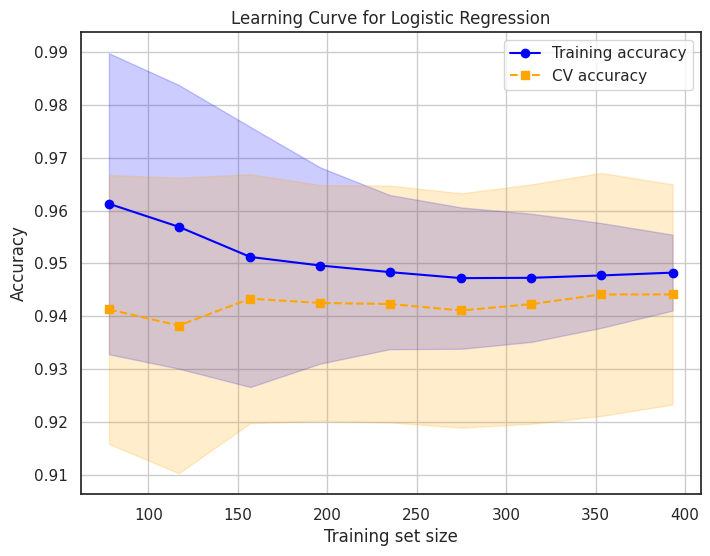

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, learning_curve, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

cv_results = {}
for metric_name, scorer in scoring_metrics.items():
    scores = cross_val_score(model_LR, hcv_X_train_logr_5, hcv_y_train_logr, cv=cv, scoring=scorer)
    cv_results[metric_name] = (scores.mean(), scores.std())

print("Cross-validation metrics (mean ± std):")
for metric, (mean_score, std_score) in cv_results.items():
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")

# ------------------------------
# 3️⃣ Learning curve
# ------------------------------
train_sizes, train_scores, test_scores = learning_curve(
    model_LR,
    hcv_X_train_logr_5,
    hcv_y_train_logr,
    cv=cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# ------------------------------
# 4️⃣ Plot learning curve
# ------------------------------
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, 's--', color='orange', label='CV accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')

plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Logistic Regression")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [221]:
hcv_y_test[hcv_y_test == 1].count()

np.int64(16)

In [222]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# ------------------------------
# Define model
# ------------------------------
model_LR = LogisticRegression(max_iter=1000, multi_class='auto', class_weight='balanced')

# ------------------------------
# Define stratified repeated CV
# ------------------------------
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)  # 5-fold CV, repeated 10 times

# ------------------------------
# Define scorer for recall of class 1
# ------------------------------
recall_class1_scorer = make_scorer(recall_score, pos_label=1)

# ------------------------------
# Cross-validate recall
# ------------------------------
recall_scores = cross_val_score(model_LR, hcv_X_train_logr_5, hcv_y_train_logr,
                                cv=cv, scoring=recall_class1_scorer)

# ------------------------------
# Report results
# ------------------------------
print(f"Class 1 recall (mean ± std): {recall_scores.mean():.3f} ± {recall_scores.std():.3f}")
print(f"Min recall across folds: {recall_scores.min():.3f}")
print(f"Max recall across folds: {recall_scores.max():.3f}")


Class 1 recall (mean ± std): 0.893 ± 0.090
Min recall across folds: 0.692
Max recall across folds: 1.000


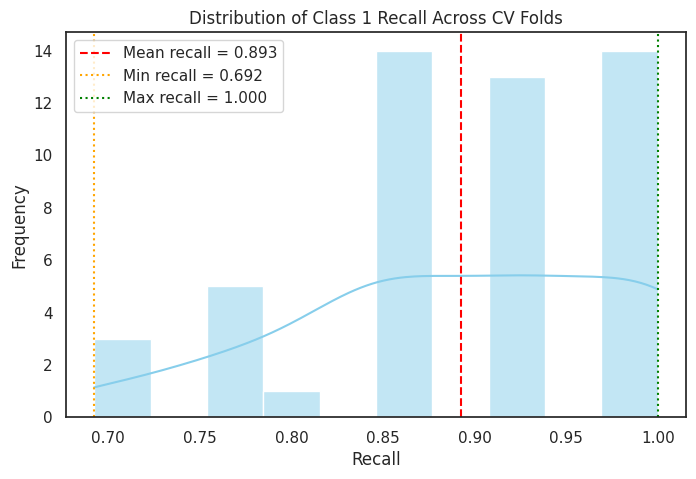

Mean recall: 0.893
Std recall: 0.090
Min recall: 0.692
Max recall: 1.000


In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.linear_model import LogisticRegression

# Define model
model_LR = LogisticRegression(max_iter=1000, multi_class='auto', class_weight='balanced')

# Define stratified repeated CV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Define scorer for recall of class 1
recall_class1_scorer = make_scorer(recall_score, pos_label=1)

# Cross-validate recall
recall_scores = cross_val_score(model_LR, hcv_X_train_logr_5, hcv_y_train_logr,
                                cv=cv, scoring=recall_class1_scorer)

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(recall_scores, bins=10, kde=True, color='skyblue')
plt.axvline(recall_scores.mean(), color='red', linestyle='--', label=f"Mean recall = {recall_scores.mean():.3f}")
plt.axvline(recall_scores.min(), color='orange', linestyle=':', label=f"Min recall = {recall_scores.min():.3f}")
plt.axvline(recall_scores.max(), color='green', linestyle=':', label=f"Max recall = {recall_scores.max():.3f}")
plt.title("Distribution of Class 1 Recall Across CV Folds")
plt.xlabel("Recall")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Optional: also print summary statistics
print(f"Mean recall: {recall_scores.mean():.3f}")
print(f"Std recall: {recall_scores.std():.3f}")
print(f"Min recall: {recall_scores.min():.3f}")
print(f"Max recall: {recall_scores.max():.3f}")

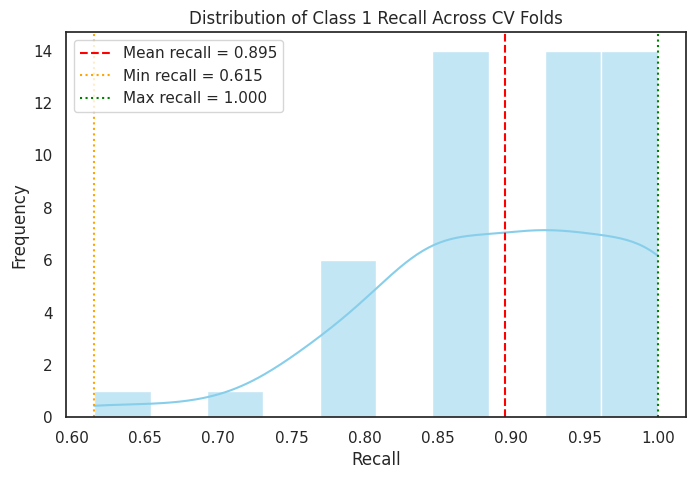

Mean recall: 0.895
Std recall: 0.090
Min recall: 0.615
Max recall: 1.000


In [224]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.linear_model import LogisticRegression

# Define model
model_LR = LogisticRegression(max_iter=1000, multi_class='auto', class_weight='balanced')

# Define stratified repeated CV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Define scorer for recall of class 1
recall_class1_scorer = make_scorer(recall_score, pos_label=1)

# Cross-validate recall
recall_scores = cross_val_score(model_LR, hcv_X_train_logr_6, hcv_y_train_logr,
                                cv=cv, scoring=recall_class1_scorer)

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(recall_scores, bins=10, kde=True, color='skyblue')
plt.axvline(recall_scores.mean(), color='red', linestyle='--', label=f"Mean recall = {recall_scores.mean():.3f}")
plt.axvline(recall_scores.min(), color='orange', linestyle=':', label=f"Min recall = {recall_scores.min():.3f}")
plt.axvline(recall_scores.max(), color='green', linestyle=':', label=f"Max recall = {recall_scores.max():.3f}")
plt.title("Distribution of Class 1 Recall Across CV Folds")
plt.xlabel("Recall")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Optional: also print summary statistics
print(f"Mean recall: {recall_scores.mean():.3f}")
print(f"Std recall: {recall_scores.std():.3f}")
print(f"Min recall: {recall_scores.min():.3f}")
print(f"Max recall: {recall_scores.max():.3f}")

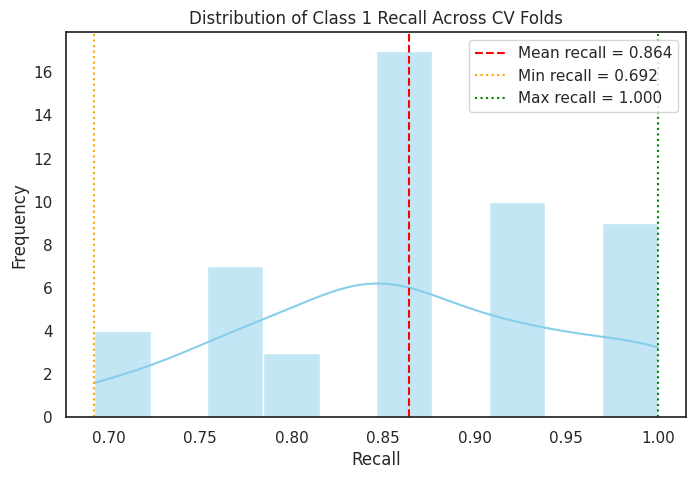

Mean recall: 0.864
Std recall: 0.089
Min recall: 0.692
Max recall: 1.000


In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.linear_model import LogisticRegression

# Define model
model_LR = LogisticRegression(max_iter=1000, multi_class='auto', class_weight='balanced')

# Define stratified repeated CV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Define scorer for recall of class 1
recall_class1_scorer = make_scorer(recall_score, pos_label=1)

# Cross-validate recall
recall_scores = cross_val_score(model_LR, hcv_X_train_logr_full, hcv_y_train_logr,
                                cv=cv, scoring=recall_class1_scorer)

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(recall_scores, bins=10, kde=True, color='skyblue')
plt.axvline(recall_scores.mean(), color='red', linestyle='--', label=f"Mean recall = {recall_scores.mean():.3f}")
plt.axvline(recall_scores.min(), color='orange', linestyle=':', label=f"Min recall = {recall_scores.min():.3f}")
plt.axvline(recall_scores.max(), color='green', linestyle=':', label=f"Max recall = {recall_scores.max():.3f}")
plt.title("Distribution of Class 1 Recall Across CV Folds")
plt.xlabel("Recall")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Optional: also print summary statistics
print(f"Mean recall: {recall_scores.mean():.3f}")
print(f"Std recall: {recall_scores.std():.3f}")
print(f"Min recall: {recall_scores.min():.3f}")
print(f"Max recall: {recall_scores.max():.3f}")

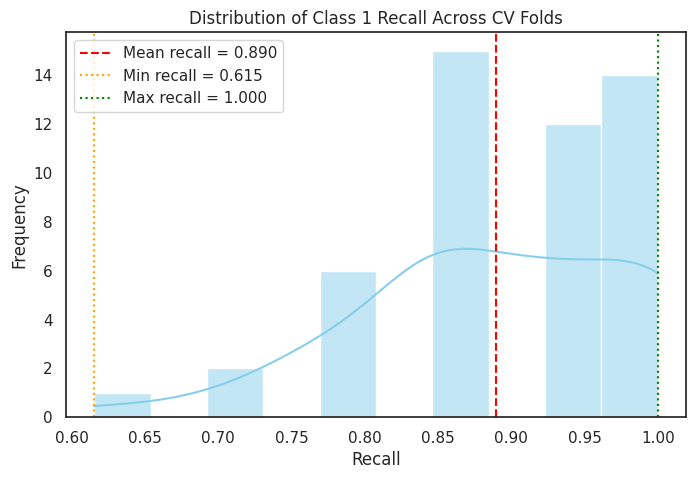

Mean recall: 0.890
Std recall: 0.094
Min recall: 0.615
Max recall: 1.000


In [226]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.linear_model import LogisticRegression

# Define model
model_LR = LogisticRegression(max_iter=1000, multi_class='auto', class_weight='balanced')

# Define stratified repeated CV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Define scorer for recall of class 1
recall_class1_scorer = make_scorer(recall_score, pos_label=1)

# Cross-validate recall
recall_scores = cross_val_score(model_LR, hcv_X_train_logr_selected, hcv_y_train_logr,
                                cv=cv, scoring=recall_class1_scorer)

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(recall_scores, bins=10, kde=True, color='skyblue')
plt.axvline(recall_scores.mean(), color='red', linestyle='--', label=f"Mean recall = {recall_scores.mean():.3f}")
plt.axvline(recall_scores.min(), color='orange', linestyle=':', label=f"Min recall = {recall_scores.min():.3f}")
plt.axvline(recall_scores.max(), color='green', linestyle=':', label=f"Max recall = {recall_scores.max():.3f}")
plt.title("Distribution of Class 1 Recall Across CV Folds")
plt.xlabel("Recall")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Optional: also print summary statistics
print(f"Mean recall: {recall_scores.mean():.3f}")
print(f"Std recall: {recall_scores.std():.3f}")
print(f"Min recall: {recall_scores.min():.3f}")
print(f"Max recall: {recall_scores.max():.3f}")

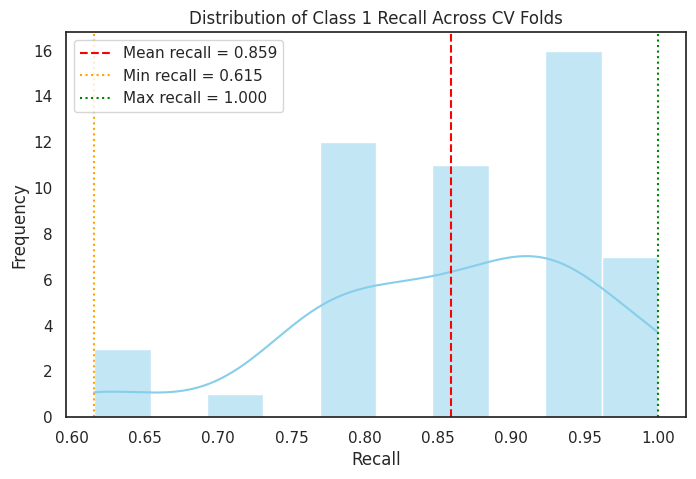

Mean recall: 0.859
Std recall: 0.100
Min recall: 0.615
Max recall: 1.000


In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.linear_model import LogisticRegression

# Define model
model_LR = LogisticRegression(max_iter=1000, multi_class='auto', class_weight='balanced')

# Define stratified repeated CV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Define scorer for recall of class 1
recall_class1_scorer = make_scorer(recall_score, pos_label=1)

# Cross-validate recall
recall_scores = cross_val_score(model_LR, hcv_X_train_logr_selected_strict, hcv_y_train_logr,
                                cv=cv, scoring=recall_class1_scorer)

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(recall_scores, bins=10, kde=True, color='skyblue')
plt.axvline(recall_scores.mean(), color='red', linestyle='--', label=f"Mean recall = {recall_scores.mean():.3f}")
plt.axvline(recall_scores.min(), color='orange', linestyle=':', label=f"Min recall = {recall_scores.min():.3f}")
plt.axvline(recall_scores.max(), color='green', linestyle=':', label=f"Max recall = {recall_scores.max():.3f}")
plt.title("Distribution of Class 1 Recall Across CV Folds")
plt.xlabel("Recall")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Optional: also print summary statistics
print(f"Mean recall: {recall_scores.mean():.3f}")
print(f"Std recall: {recall_scores.std():.3f}")
print(f"Min recall: {recall_scores.min():.3f}")
print(f"Max recall: {recall_scores.max():.3f}")

# **Logistic Regression - Ranking**

## Main considerations
**1. What were your main considerations when selecting the best model?**


## Model explanation - Positive diagnosis
**2. Explain how your best model makes the decision for a positive diagnosis.**



## Model explanation - Over/underfitting, anchoring biases
**3. Explain how your proposed model addresses overfitting, underfitting, or anchoring biases *(choose one)* in training.**

# Random Forest

* Train RF model
* Compare performance to the best LR model.
* Explain how RF model makes decisions, using:
* Feature importance measures
* SHAP values


## Random Forest model

Splitting dataset into features and target

In [228]:
"""
features = hcv_normalized.drop(columns='Category')
target = hcv_normalized['Category']
"""

"\nfeatures = hcv_normalized.drop(columns='Category')\ntarget = hcv_normalized['Category']\n"

Checking the best split and depth scenario

F1-score for test-train ratio 0.2 and depth 4 is 0.9665462210177657


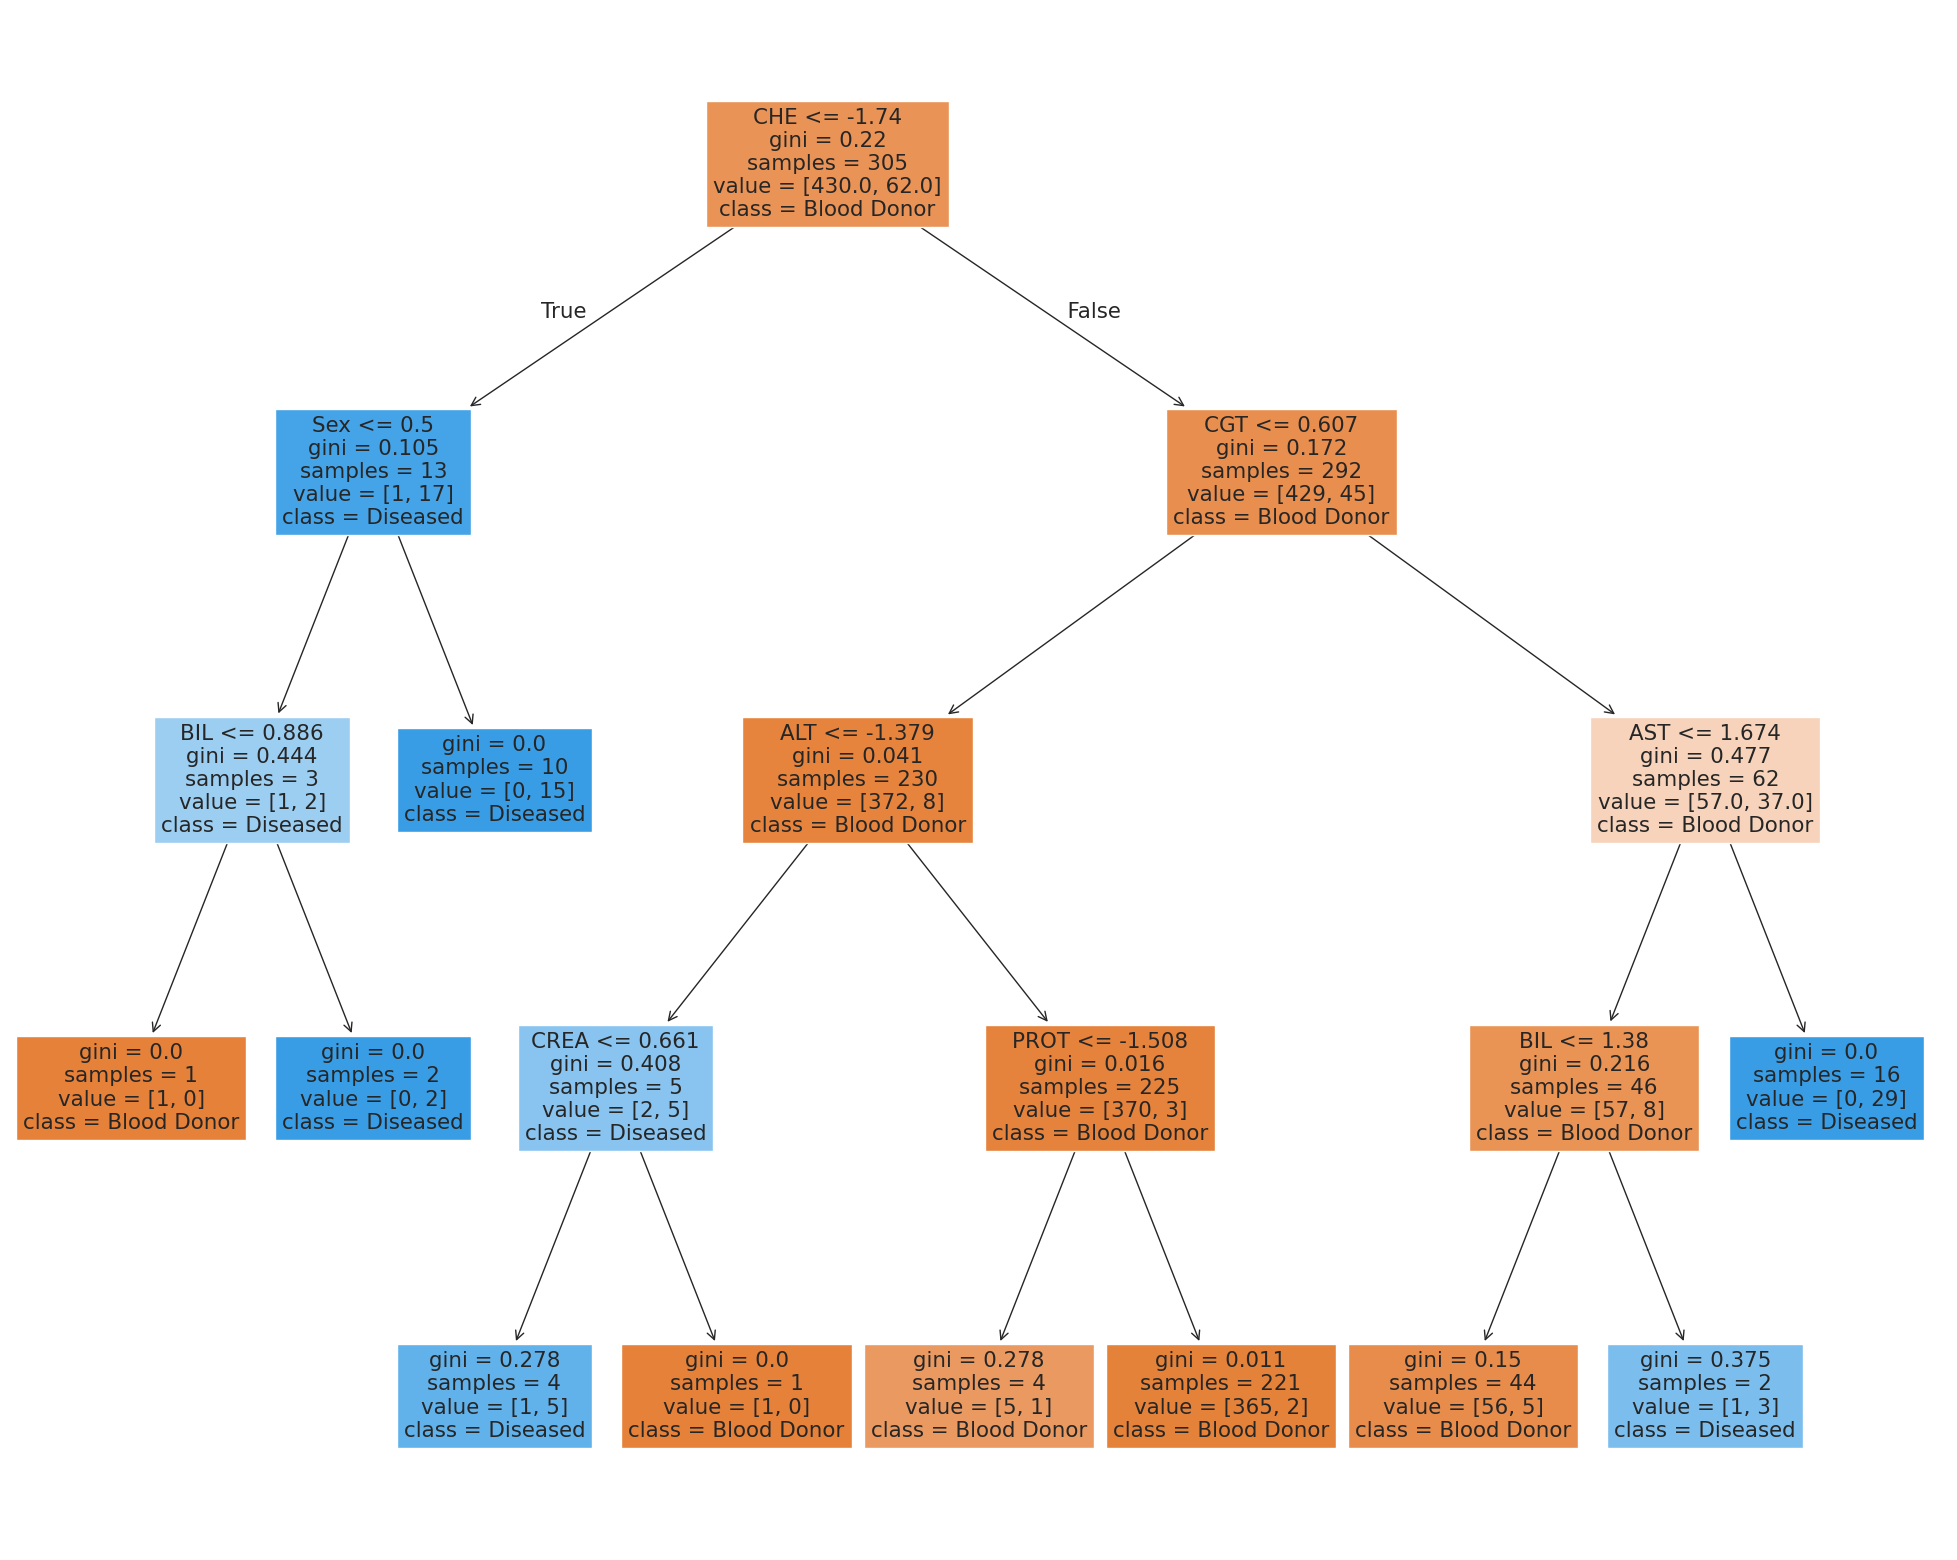

In [229]:
"""x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 3003)"""

x_train = hcv_X_train.copy()
x_test = hcv_X_test.copy()
y_train = hcv_y_train.copy()
y_test = hcv_y_test.copy()

model_rf = RandomForestClassifier(max_depth = 4,random_state = 3003)
model_rf.fit(x_train, y_train)
feature_names = x_train.columns
y_pred = model_rf.predict(x_test)
print(f"F1-score for test-train ratio {0.20} and depth {4} is {f1_score(y_test, y_pred, average='weighted')}")

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_rf.estimators_[0], # Access one tree from the forest for visualization
                   feature_names=feature_names,
                   class_names=['Blood Donor', 'Diseased'], # Provide class names
                   filled=True)

Accuracy :  96.75%
Cross Validation Score :  97.77%
ROC_AUC Score :  90.16%


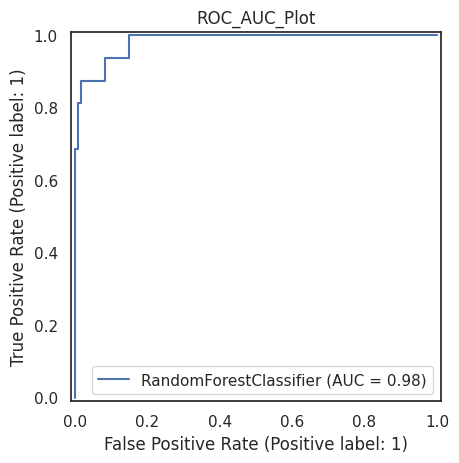

In [230]:
model_desc(model_rf)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       107
           1       0.93      0.81      0.87        16

    accuracy                           0.97       123
   macro avg       0.95      0.90      0.92       123
weighted avg       0.97      0.97      0.97       123



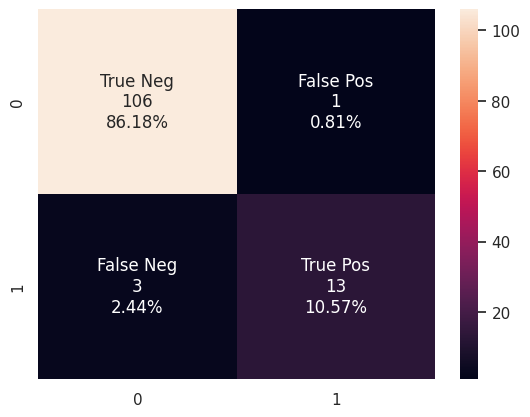

In [231]:
model_evaluation(model_rf)

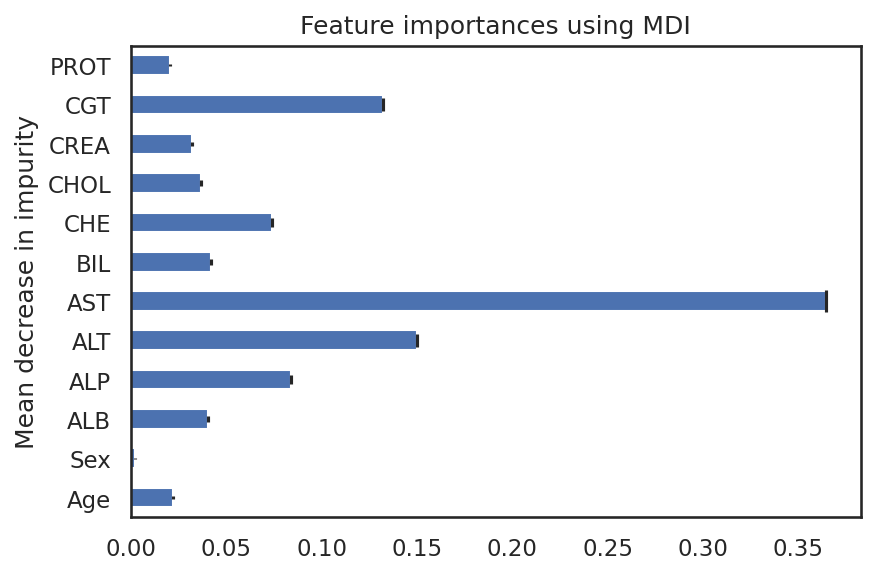

In [232]:
importances = model_rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)


fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

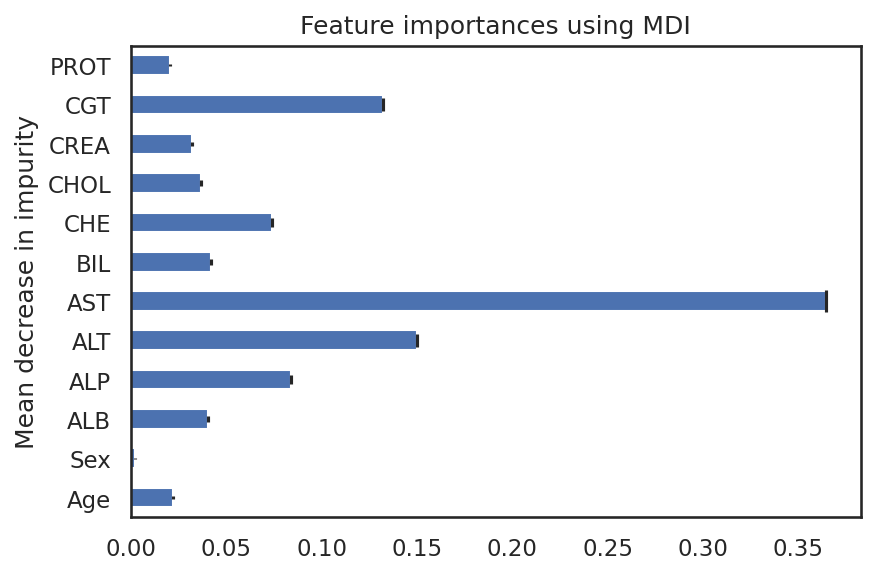

In [233]:
# Impurity-based feature importance: Mean Decrease in Impurity (MDI)
importances = model_rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)


fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

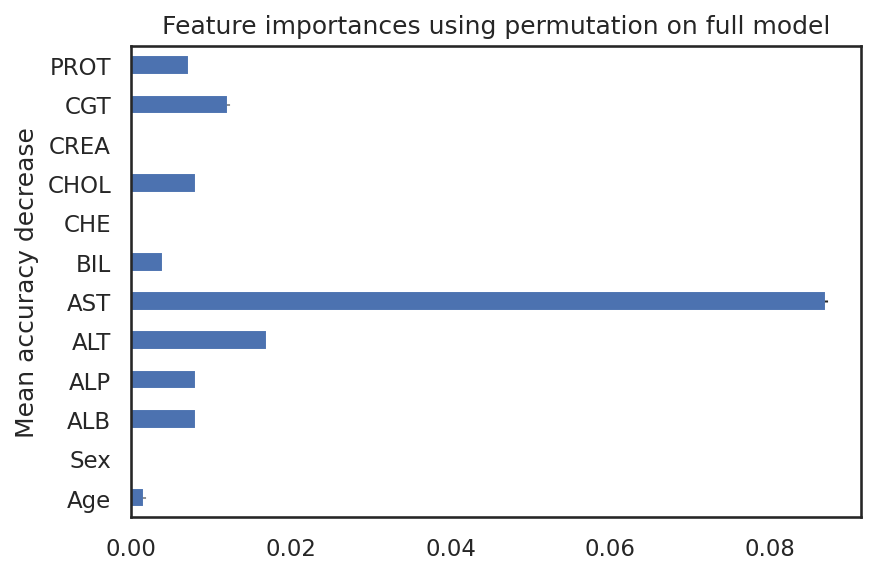

In [234]:
result = permutation_importance(
    model_rf, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
forest_importances.plot.barh(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## SHAP values

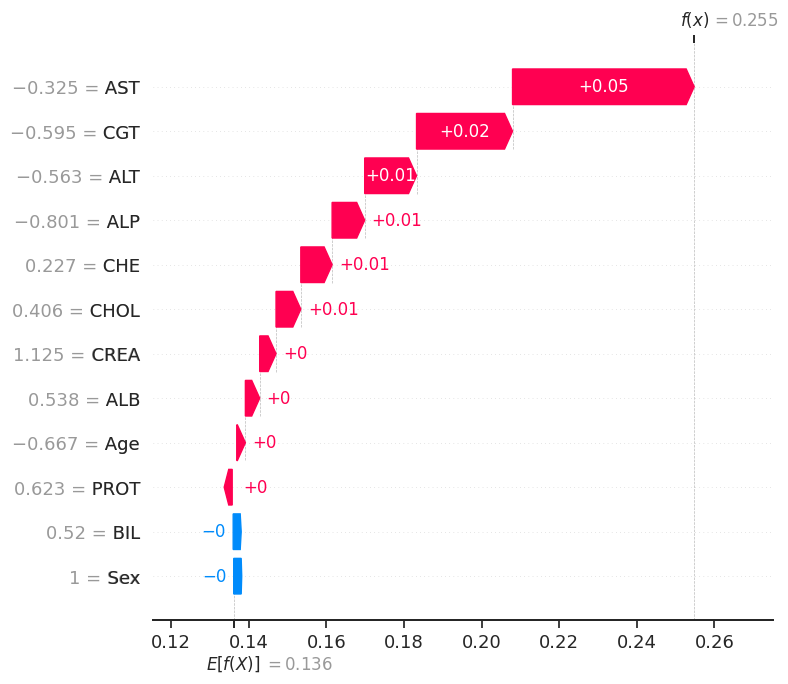

In [235]:
explainer = shap.TreeExplainer(model_rf)
explanation = explainer(x_train)
explanation.values = explanation.values[:,:,0]
explanation.base_values = explanation.base_values[0,1]

shap.plots.waterfall(explanation[0], max_display=20)

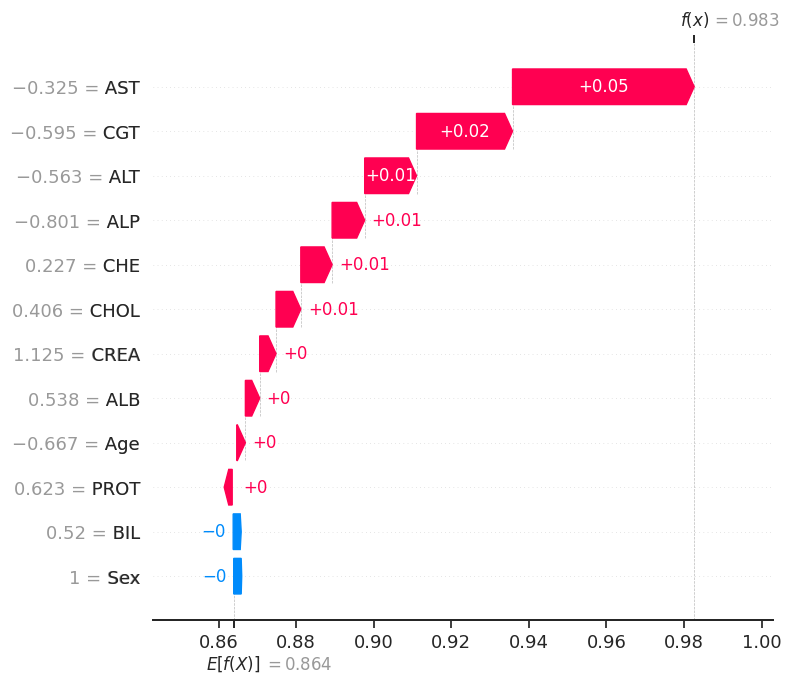

In [236]:
explainer = shap.TreeExplainer(model_rf)
explanation = explainer(x_train)

id_to_explain = 0
output_to_explain = 0
shap.plots.waterfall(explanation[id_to_explain,:,output_to_explain], max_display=20)

In [237]:
explainer = shap.TreeExplainer(model_rf)
explanation = explainer(x_train)

id_to_explain = 0
output_to_explain = 0
shap.plots.force(explanation[id_to_explain,:,output_to_explain])

In [238]:
# Overall effect of features on decision
explainer = shap.TreeExplainer(model_rf)
explanation = explainer(x_train)

shap_values = explainer.shap_values(x_test)

print(explanation[1])

.values =
array([[ 1.33959765e-03, -1.33959765e-03],
       [-8.79722679e-05,  8.79722679e-05],
       [ 3.47257809e-03, -3.47257809e-03],
       [ 9.68560452e-03, -9.68560452e-03],
       [ 1.55367459e-02, -1.55367459e-02],
       [ 4.63171481e-02, -4.63171481e-02],
       [ 8.19432177e-03, -8.19432177e-03],
       [ 8.07869916e-03, -8.07869916e-03],
       [ 2.28177565e-03, -2.28177565e-03],
       [ 7.05084544e-04, -7.05084544e-04],
       [ 2.37349987e-02, -2.37349987e-02],
       [ 2.05549818e-03, -2.05549818e-03]])

.base_values =
array([0.86390244, 0.13609756])

.data =
array([ 0.6       ,  1.        ,  0.2       ,  0.95171436, -0.15301355,
       -0.38924419, -0.08963721, -0.16782626, -0.27272727, -0.64171169,
       -0.22621237, -0.16393443])


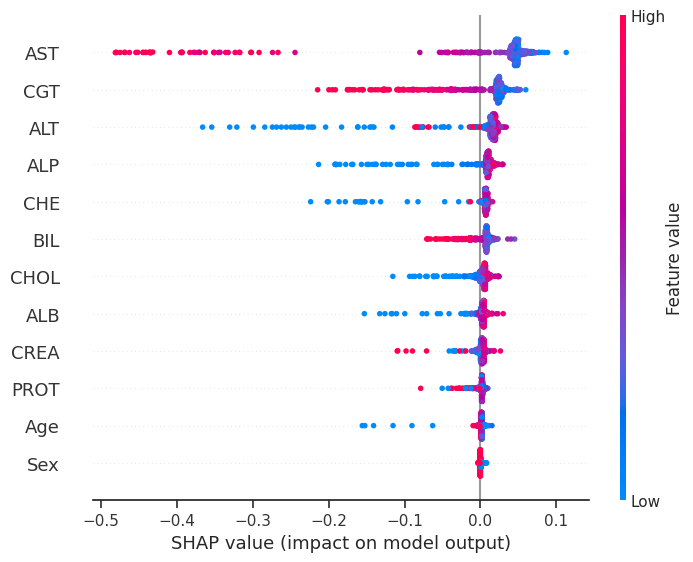

In [239]:
shap.plots.beeswarm(explanation[:,:,0],max_display=20)

# Comparing best LR with RF

In [240]:
### REQUIRED LIBRARIES ###
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [241]:
y_prob_logreg = model_LR_best.predict_proba(hcv_X_test_logr_selected)[:,1]
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(hcv_y_test_logr, y_prob_logreg)
auc_logreg = auc(fpr_logreg, tpr_logreg)

#AUC for random forest
y_prob_RF = model_rf.predict_proba(x_test)[:,1]
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_prob_RF)
auc_RF = auc(fpr_RF, tpr_RF)

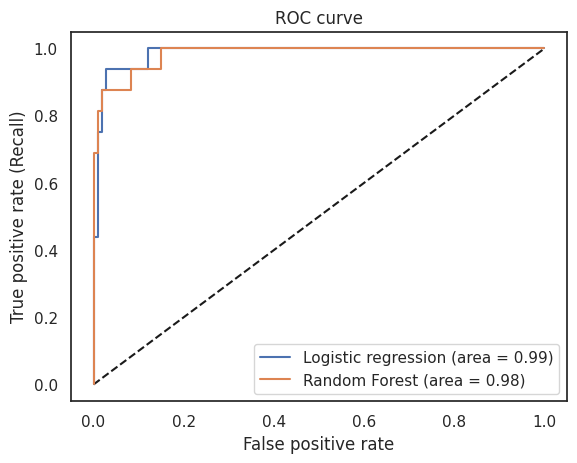

In [242]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_logreg, tpr_logreg, label='Logistic regression (area = {:.2f})'.format(auc_logreg))
ax.plot(fpr_RF, tpr_RF, label='Random Forest (area = {:.2f})'.format(auc_RF))
ax.set(xlabel='False positive rate',
       ylabel='True positive rate (Recall)',
       title='ROC curve')
ax.legend(loc='best');

In [244]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

"""from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler() #??
X = min_max_scaler.fit_transform(X)"""

# Evaluate the model using cross-validation
scores = cross_val_score(model_rf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# options for scoring: scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Print the average accuracy and the standard deviation
print('Accuracy: %.3f \u00B1 %.3f' % (np.mean(scores), np.std(scores)))

Accuracy: 0.958 ± 0.017
